# COMP0188 Coursework 2: Age Regression from Brain MRIs (30 Marks)

MRI scans can be used to determine volumes of different types of brain tissue which are associated with age. In particular, as patients age, it is known that the ventricles enlarge (as they get filled with cerebrospinal fluid), while the volume of grey and white matter volume may decrease.

Your task is to develop a deep learning model capable of predicting the (biological) age of a patient from MRI scans. Such a tool could be used in clinical practice to compare a patients 'biological' age against their 'true' chronological age. A significant discrepency in these ages might indicate the presense of a disease in the patient. 

You have been provided with a dataset of healthy patients. The dataset contains MRI scans of the patients, and their corresponing chronological ages (amongst other information). As the patients are healthy, we will assume that their biological and chronological ages are equal.

We have provided you with helper code, and have marked additional code you will need to implement with "🚧 **Exercise** 🚧". However, you are not bound to this code (i.e. you may modify it if you wish), or even this notebook - you may complete the coursework however you see fit.

#### Notebook Overview
The notebook is split into 3 parts:

- Part 1: Dataset analysis and defining a suitable setup (8 marks)
- Part 2: Baseline model definition (7 marks)
- Part 3: Improving upon the Baseline (15 marks)

Please see the introduction for each section for more information.

#### Loading the Dataset and Running the Notebook

Use Google Colab to run the notebook. Run the cells in sequence, as per usual.

### Requirements
* SimpleITK
* wandb

### Dependancies

In [1]:
!pip install SimpleITK gdown wandb

In [2]:
!pip install torch

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import wandb

from typing import List, Dict, Tuple, Literal
import pickle
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

import gdown
import zipfile
import os
import psutil

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def check_memory_used():
    process = os.getpid()
    proc = psutil.Process(process)
    memory_info = proc.memory_info()
    print(f"Memory Used: {memory_info.rss / (1024**3):.2f} GB")  # RSS (Resident Set Size)

### Global config

In [4]:
# Used for debugging the notebook locally. Leave as True when running in colab!
download = False

# Expect the download to take roughly 3 mins
if download:
    # Replace this with your Google Drive shared link or file ID
    google_drive_shared_link = 'https://drive.google.com/file/d/1OzIzn9tLUmq74I6YB5_nTnvaV_R1v7kj/view?usp=sharing'
    file_id = google_drive_shared_link.split('/')[-2]

    # Construct the gdown URL
    download_url = f'https://drive.google.com/uc?id={file_id}'

    # Path where the downloaded file will be stored
    output_path = 'download.zip'

    # Download the file from Google Drive
    gdown.download(download_url, output_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall('data')

    # Optionally, delete the zip file after extraction
    # os.remove(output_path)
    
    data_dir = "data/coursework_1_compressed/coursework_1"
else:
    data_dir = "coursework_1_compressed/coursework_1" # "../../coursework_1/coursework_1"

In [5]:
MRI_TEMPLATE_FILE = os.path.join(data_dir, "quasiraw_space-MNI152_desc-brain_T1w.nii.gz")

In [6]:
TRAIN_DIR = os.path.join(data_dir, "train")
TRAIN_MRI_DIR = os.path.join(TRAIN_DIR, "quasiraw")
TRAIN_META_FILE = os.path.join(TRAIN_DIR, "participants.tsv")

In [7]:
TEST_DIR = os.path.join(data_dir, "test")
TEST_MRI_DIR = os.path.join(TEST_DIR, "quasiraw")
TEST_META_FILE = os.path.join(TEST_DIR, "participants.tsv")

In [8]:
OUT_SPACING = [2, 2, 2]
OUT_SIZE = [96, 96, 96]

## Part 1: Dataset analysis and define a suitable setup

### Dataset analysis

It is important to analyse your dataset to better understand it and to help detect any issues in the dataset. This can be done via visualizations and calculating statistics from the available information.

### Defining a suitable seup

Before performing any kind of model development, it is critical to define the scope of the model development process. This includes making decisions which stay fixed throughout the rest of the model development; as changing them would render model comparisons invalid. For example, comparing two models with test score calculated on different test datasets or with different metrics is meaningless.

This section should help you answer following questions:
* How should the train/validation/test set be split?
* What metric will be used to assess model performance on the test set?
    * It is critical to consider the broader project metric when setting this. In this case the project metric is to "predict the patients biological age from MRI scans". Furthermore, we want to make sure that the model can predict age well for _all_ patients, not just a subset (which may happen if the input data is skewed, for example).

_Hint_: 
* Consider the following kinds of analysis:
    * What relevant variables are available in the dataset? Do they need to be transformed?
    * What does the target variable look like?
    * Is the data sufficiently balanced?
    * What is the distribution of other variables?

### Dataset description
* The data provided has already been split into a training and test dataset. Both the training and test data contain: (i) a file of images in the form of numpy arrays (the MRIs); (ii) a tab seperated file called "participants.tsv" which contains structured data for each patient (including the overall target of interest "age").
* The "participant_id" column defines a unique ID for each patient and can be used to link the structured data with the MRI scans. In particular, the patient with participant_id = "100053248969" has an associated MRI scan in the file "sub-100053248969_preproc-quasiraw_T1w.npy"

The code below provides some helper functions for to import the relevant data for analysis

In [9]:
num_vars = ["age", "tiv", "csfv", "gmv", "wmv", "magnetic_field_strength", "acquisition_setting"]

# Load the training data
train_meta_df = pd.read_csv(TRAIN_META_FILE, delimiter='\t', dtype=str)
train_meta_df[num_vars] = train_meta_df[num_vars].astype(float)
train_meta_df["age_round"] = np.round(train_meta_df["age"],0).astype(int)
print(train_meta_df.shape)

bins = list(range(0, 80, 10))
bins.append(110)
train_meta_df["age_10_yr_bckt_bg_70"] = pd.cut(train_meta_df["age"], bins=bins)
print(train_meta_df["age_10_yr_bckt_bg_70"].value_counts())
train_meta_df["age_10_yr_bckt"] = pd.cut(train_meta_df["age"], bins=range(0, 110, 10))
print(train_meta_df["age_10_yr_bckt"].value_counts())

# Also load the test data - BUT DON'T LOOK AT IT!
test_meta_df = pd.read_csv(TEST_META_FILE, delimiter='\t', dtype=str)
test_meta_df[num_vars] = test_meta_df[num_vars].astype(float)
test_meta_df["age_round"] = np.round(train_meta_df["age"],0).astype(int)
print(test_meta_df.shape)

test_meta_df["age_10_yr_bckt_bg_70"] = pd.cut(test_meta_df["age"], bins=bins)
print(test_meta_df["age_10_yr_bckt_bg_70"].value_counts())
test_meta_df["age_10_yr_bckt"] = pd.cut(test_meta_df["age"], bins=range(0, 110, 10))
print(test_meta_df["age_10_yr_bckt"].value_counts())

train_meta_df.head()

(466, 13)
age_10_yr_bckt_bg_70
(20, 30]     220
(10, 20]     152
(30, 40]      24
(0, 10]       21
(60, 70]      18
(40, 50]      14
(50, 60]       9
(70, 110]      8
Name: count, dtype: int64
age_10_yr_bckt
(20, 30]     220
(10, 20]     152
(30, 40]      24
(0, 10]       21
(60, 70]      18
(40, 50]      14
(50, 60]       9
(70, 80]       8
(80, 90]       0
(90, 100]      0
Name: count, dtype: int64
(167, 14)
age_10_yr_bckt_bg_70
(20, 30]     84
(10, 20]     53
(0, 10]      10
(30, 40]      9
(40, 50]      4
(60, 70]      4
(50, 60]      2
(70, 110]     1
Name: count, dtype: int64
age_10_yr_bckt
(20, 30]     84
(10, 20]     53
(0, 10]      10
(30, 40]      9
(40, 50]      4
(60, 70]      4
(50, 60]      2
(70, 80]      1
(80, 90]      0
(90, 100]     0
Name: count, dtype: int64


participant_id study     sex   age  site diagnosis          tiv        csfv  \
0   100053248969     8  female  19.0  48.0   control  1434.357361  219.565569   
1   100263562592     4    male  21.0   3.0   control  1558.161428  261.968669   
2   100479214233     2  female  21.0  29.0   control  1418.050690  242.123816   
3   100544064116     3  female  15.0  65.0   control  1304.233543  206.305238   
4   101404752059     4    male  31.0   3.0   control  1660.856147  344.783456   

          gmv         wmv  magnetic_field_strength  acquisition_setting  \
0  678.230161  535.878459                      3.0                  1.0   
1  756.742506  538.817738                      3.0                  1.0   
2  686.814910  488.740580                      3.0                  1.0   
3  667.809720  429.723510                      3.0                  1.0   
4  703.484560  611.222413                      3.0                  1.0   

   age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  
0         19             (10, 20]       (10, 20]  
1         21             (20, 30]       (20, 30]  
2         21             (20, 30]       (20, 30]  
3         15             (10, 20]       (10, 20]  
4         31             (30, 40]       (30, 40]

Descriptions for relevant (non-self-descriptive) column names:
- **participant_id:** Unique ID for each patient, can be used to link to the MRI scans.
- **csfv:** Cerebrospinalfluid volume
- **gmv:** Grey matter volume
- **wmv:** White matter volume


In [10]:
def load_patient_mri_array(
    patient_id:str,
    mri_dir:str
    ) -> np.array:
    """Function to load a patient .nii.gz file containing an MRI 3D scan into a
    numpy array
    
    Args:
        patient_id (str): Patient ID string
        mri_dir (str): String representing the directory containing the MRI
        .nii.gz files
        
    Returns:
        np.array: 3D numpy array representing the MRI scan
    """
    mri_file = f"nifti/sub-{patient_id}_preproc-quasiraw_T1w.nii.gz"
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(mri_dir, mri_file)))
    return np.expand_dims(img_array, axis=0)
    
def vis_raw_mri_image(
    img_array:np.array, 
    x:int=None, 
    y:int=None, 
    z:int=None, 
    crosshair:bool=False, 
    template_file:str=MRI_TEMPLATE_FILE
):
    """Function to display orthogonal 2D slices of the 3D MRI image

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan
        x (int, optional): x slice co-ordinate. Defaults to None.
        y (int, optional): y slice co-ordinate. Defaults to None.
        z (int, optional): z slice co-ordinate. Defaults to None.
        crosshair (bool, optional): Flag that determines whether the images 
        should be shown with x/y lines across the centres of the axes. 
        Defaults to False.
        template_file (str, optional): String representing the MRI template file
        to extract the image dimensions. Defaults to MRI_TEMPLATE_FILE.
    """
    template = sitk.ReadImage(template_file)
    size = template.GetSize()
    spacing = template.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    # Display the orthogonal slices    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
    
    ax1.imshow(img_array[z,:,:], extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)
    
    plt.show()

Let's use the helper functions above to visualise the MRI scans for patient "100053248969"

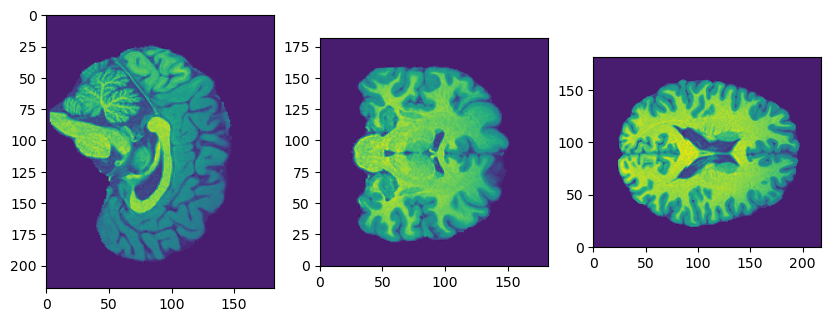

(1, 182, 218, 182)

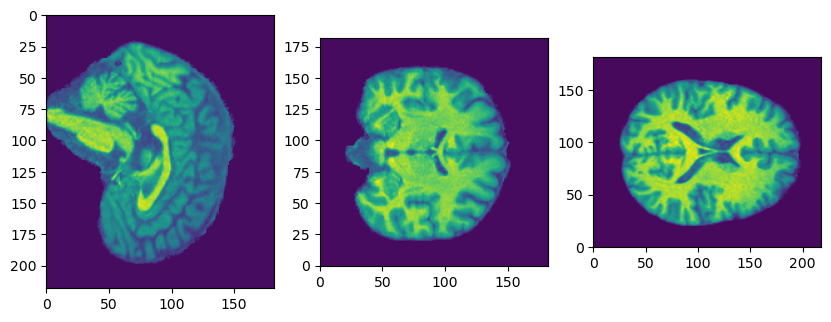

(1, 182, 218, 182)

In [11]:
img_array = load_patient_mri_array("100053248969", mri_dir=TRAIN_MRI_DIR) ## age 19
vis_raw_mri_image(img_array.squeeze())
display(img_array.shape)

img_array = load_patient_mri_array("101404752059", mri_dir=TRAIN_MRI_DIR) ## age 31
vis_raw_mri_image(img_array.squeeze())
display(img_array.shape)

🚧 **Exercise 1.1** 🚧

Below, perform any data analysis / data visualizations you think will be useful. These may help you better understand the distribution and demographics of the dataset.

In [12]:
####################
# Insert code here #
####################

# First, understand the types of the columns to decide how to analyse them
data_types = train_meta_df.dtypes
unique_datatypes = data_types.unique()
print(unique_datatypes)

[dtype('O') dtype('float64') dtype('int64')
 CategoricalDtype(categories=[(0, 10], (10, 20], (20, 30], (30, 40], (40, 50], (50, 60], (60, 70], (70, 110]], ordered=True)
 CategoricalDtype(categories=[(0, 10], (10, 20], (20, 30], (30, 40], (40, 50], (50, 60], (60, 70], (70, 80], (80, 90], (90, 100]], ordered=True)]


In [13]:
# Split the columns to numeric and categorical, as each of those types required a different analysis
numeric_cols_types = {np.dtype('float64'), np.dtype('int64')}
numeric_cols = {col for col in data_types.keys() if (data_types[col] in numeric_cols_types)}
categorical_cols = {col for col in data_types.keys() if (data_types[col] not in numeric_cols_types)}
print(f"There are {len(numeric_cols)} numerical columns in the dataset and {len(categorical_cols)} categorical columns")

There are 8 numerical columns in the dataset and 7 categorical columns


In [14]:
train_meta_df["site"] = train_meta_df["site"].apply(lambda x: x[:-2])


 Analysing Categorical Feature: ***study***
num of unique values for the feature is 10. The values are:
['8' '4' '2' '3' '6' '1' '5' '9' '10' '7']
num nulls: 0
data type is object


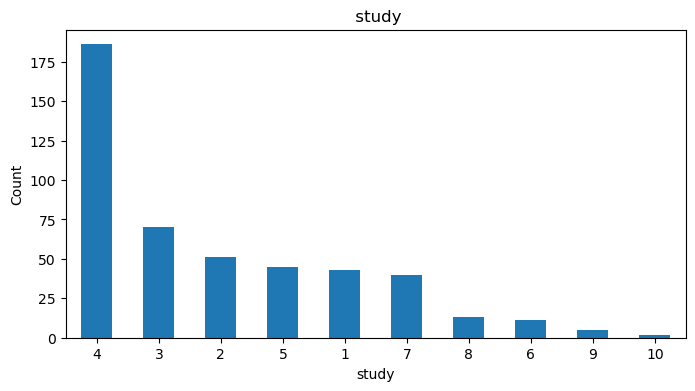


 Analysing Categorical Feature: ***diagnosis***
num of unique values for the feature is 1. The values are:
['control']
num nulls: 0
data type is object


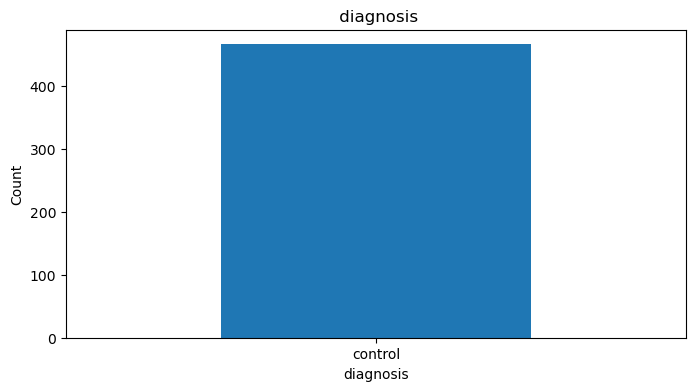


 Analysing Categorical Feature: ***sex***
num of unique values for the feature is 2. The values are:
['female' 'male']
num nulls: 0
data type is object


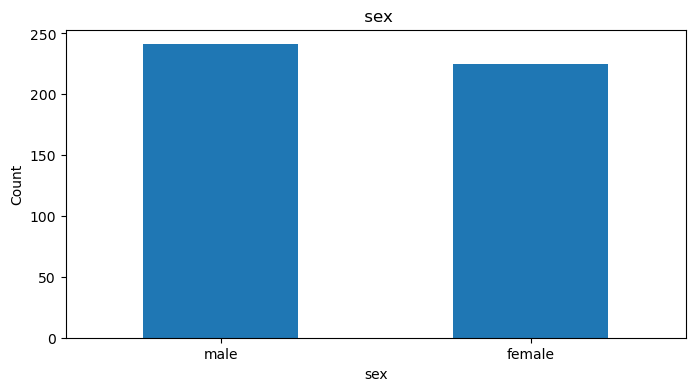


 Analysing Categorical Feature: ***age_10_yr_bckt***
num of unique values for the feature is 8. The values are:
[(10, 20], (20, 30], (30, 40], (0, 10], (60, 70], (70, 80], (40, 50], (50, 60]]
Categories (10, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (60, 70] < (70, 80] < (80, 90] < (90, 100]]
num nulls: 0
data type is category


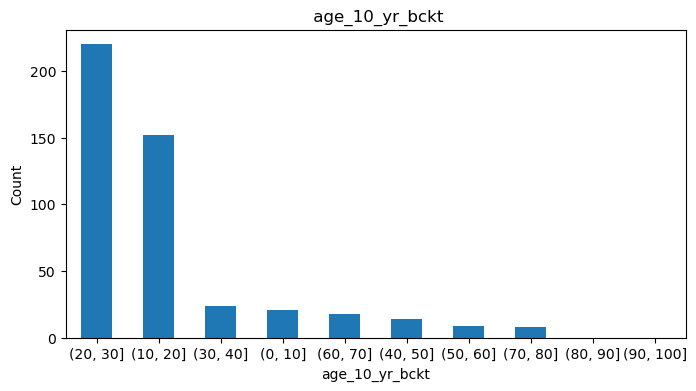


 Analysing Categorical Feature: ***age_10_yr_bckt_bg_70***
num of unique values for the feature is 8. The values are:
[(10, 20], (20, 30], (30, 40], (0, 10], (60, 70], (70, 110], (40, 50], (50, 60]]
Categories (8, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 110]]
num nulls: 0
data type is category


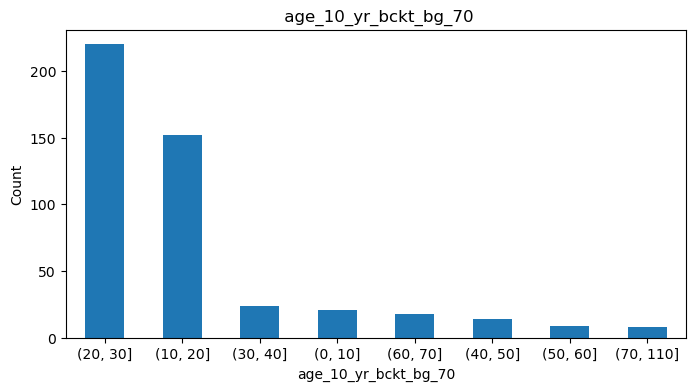


 Analysing Categorical Feature: ***site***
num of unique values for the feature is 55. The values are:
['48' '3' '29' '65' '42' '13' '24' '66' '14' '36' '40' '70' '49' '30' '38'
 '23' '27' '8' '11' '6' '21' '22' '34' '28' '17' '7' '62' '16' '47' '51'
 '63' '59' '46' '12' '60' '43' '4' '53' '50' '35' '44' '33' '52' '2' '57'
 '37' '5' '45' '18' '20' '10' '61' '9' '56' '25']
num nulls: 0
data type is object


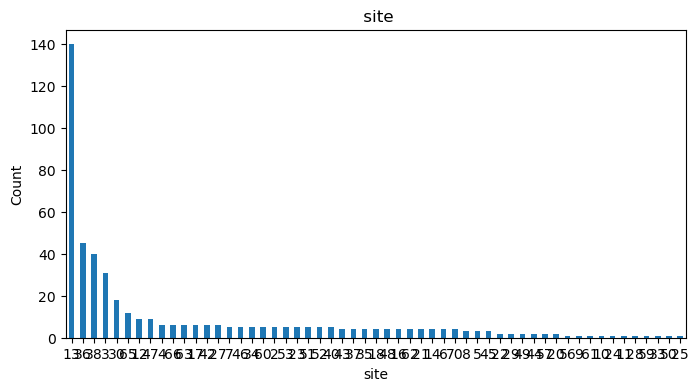

In [15]:
# Analyse categorical data

def analyse_categorical_feature(cols, df, title_prefix=""):
    for col in cols:
        print(f"\n Analysing Categorical Feature: ***{col}***")
        unique_vals = df[col].unique()
        print(f"num of unique values for the feature is {len(unique_vals)}. The values are:")
        print(unique_vals)
        num_nulls = df[col].isna().sum()
        print(f"num nulls: {num_nulls}")
        print(f"data type is {df[col].dtype}")
        if num_nulls > 0:
            print(f"Understanding Nulls:\n Here are some rows for which the column {col} got a NaN value")
            print(df[df[col].isna()].head(10))
        plt.figure(figsize=(8, 4))
        plt.title(title_prefix + " " + col)
        df[col].value_counts().plot(kind='bar', xlabel=col, ylabel='Count', rot=0)
        plt.show()

analyse_categorical_feature(categorical_cols - {"participant_id"}, train_meta_df)

In [290]:
ages_split = train_meta_df[["age_10_yr_bckt", "sex", "participant_id"]].groupby(["age_10_yr_bckt"]).count()
ages_split.head(10)

sex  participant_id
age_10_yr_bckt                     
(0, 10]          21              21
(10, 20]        152             152
(20, 30]        220             220
(30, 40]         24              24
(40, 50]         14              14
(50, 60]          9               9
(60, 70]         18              18
(70, 80]          8               8
(80, 90]          0               0
(90, 100]         0               0

In [299]:
num_participants = ages_split["participant_id"].sum()
print(num_participants)
print((152+220) / num_participants)

466
0.7982832618025751


In [300]:
ages_split = train_meta_df[["sex", "participant_id"]].groupby(["sex"]).count()
ages_split.head(2)

participant_id
sex                   
female             225
male               241

In [303]:
225 / 466

0.48283261802575106

Analizing numerical column: ***csfv***
num nulls: 0 num zeros: 0
minimum: 132.658012531396 | maximum: 488.98709019607804 | mean: 253.44248978809958 | std: 58.58350478293092


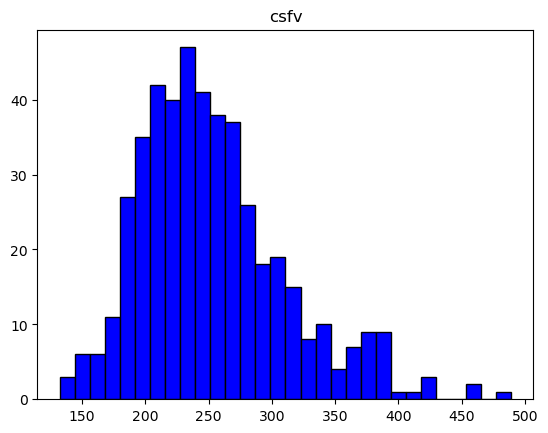

Analizing numerical column: ***age***
num nulls: 0 num zeros: 0
minimum: 6.685832 | maximum: 78.5845311430527 | mean: 24.730252048494517 | std: 13.336105435557245


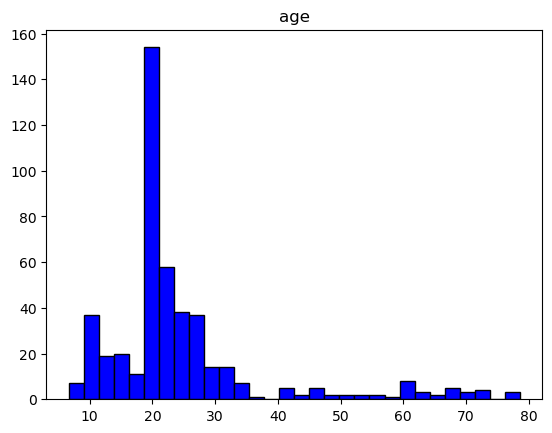

Analizing numerical column: ***tiv***
num nulls: 0 num zeros: 0
minimum: 872.1719764705881 | maximum: 1883.6213490196103 | mean: 1456.6357195846401 | std: 152.71639143875342


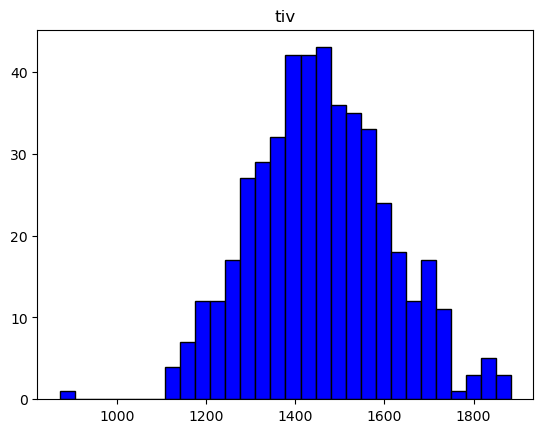

Analizing numerical column: ***wmv***
num nulls: 0 num zeros: 0
minimum: 366.67472969463796 | maximum: 731.0750078431371 | mean: 513.7186370870428 | std: 65.53866211377648


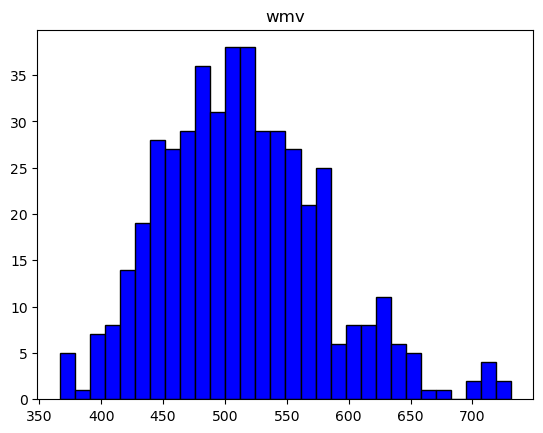

Analizing numerical column: ***magnetic_field_strength***
num nulls: 0 num zeros: 0
minimum: 1.5 | maximum: 3.0 | mean: 2.929184549356223 | std: 0.31847448920893645


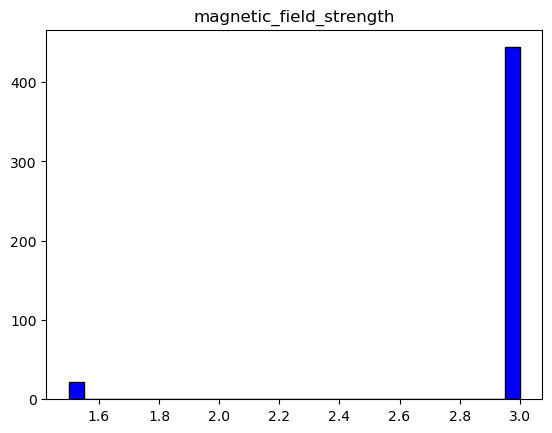

Analizing numerical column: ***gmv***
num nulls: 0 num zeros: 0
minimum: 318.006349019608 | maximum: 910.0519411764709 | mean: 688.5824933019716 | std: 88.89055567812483


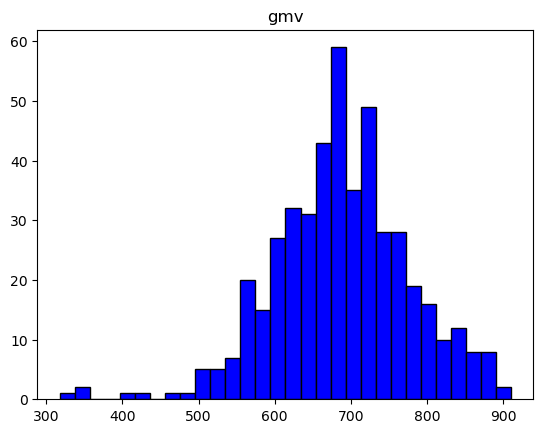

Analizing numerical column: ***age_round***
num nulls: 0 num zeros: 0
minimum: 7 | maximum: 79 | mean: 24.736051502145923 | std: 13.35346874791876


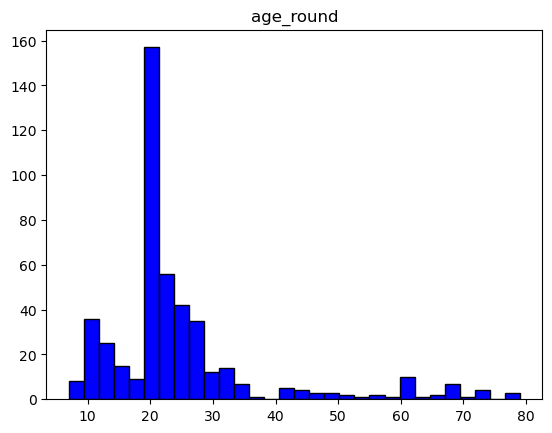

Analizing numerical column: ***acquisition_setting***
num nulls: 0 num zeros: 0
minimum: 1.0 | maximum: 3.0 | mean: 1.2360515021459229 | std: 0.5368853520192081


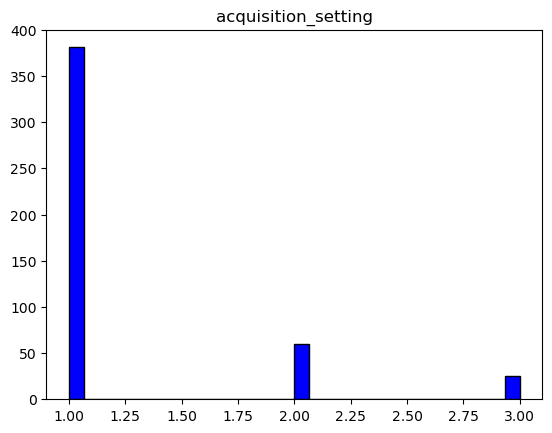

In [222]:
# Analyse numerical data

def analyse_numerical_column(col:str, df: pd.DataFrame)-> None:
    print(f"Analizing numerical column: ***{col}***")
    zeros_count = (df[col] == 0).sum()
    min_val = df[col].min()
    max_val = df[col].max()
    nulls_count = (df[col].isna()).sum()
    mean = df[col].mean()
    std = df[col].std()
    print(f"num nulls: {nulls_count} num zeros: {zeros_count}")
    print(f"minimum: {min_val} | maximum: {max_val} | mean: {mean} | std: {std}")
    plt.figure()
    plt.title(col)
    plt.hist(df[col], bins=30, color='blue', edgecolor='black')
    plt.show()

for col in numeric_cols:
    analyse_numerical_column(col, train_meta_df)

In [343]:
gmv_outliers = train_meta_df[train_meta_df["gmv"] < 450]
gmv_outliers.head(20)

participant_id study     sex        age site diagnosis          tiv  \
161   145200850196     6    male  23.000000   52   control  1247.677816   
227   167010474107     6  female  28.000000   52   control  1192.309478   
252   174763886500     5  female  61.785079   36   control  1110.237080   
373   207275791415     5  female  78.203970   36   control  1136.437218   
432   222716353013     6  female  25.000000   52   control   872.171976   

           csfv         gmv         wmv  magnetic_field_strength  \
161  463.252737  350.226396  432.928627                      3.0   
227  427.053216  348.670812  414.350694                      3.0   
252  304.969074  431.572509  372.909184                      3.0   
373  319.891943  415.707318  398.689135                      1.5   
432  141.051929  318.006349  411.831325                      3.0   

     acquisition_setting  age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  
161                  1.0         23             (20, 30]       (20, 30]  
227                  1.0         28             (20, 30]       (20, 30]  
252                  3.0         62             (60, 70]       (60, 70]  
373                  2.0         78            (70, 110]       (70, 80]  
432                  1.0         25             (20, 30]       (20, 30]

In [340]:
wmv_outliers = train_meta_df[train_meta_df["wmv"] > 680]
wmv_outliers.head(20)

participant_id study     sex        age site diagnosis          tiv  \
25    107912335979     1    male  31.000000   11   control  1827.077310   
214   162962669437     5    male  33.593429   36   control  1745.069244   
277   182985606883     3    male  59.000000   35   control  1799.355333   
287   185101775136     3  female  28.000000   18   control  1832.794247   
393   212519080242     7    male  27.500000   38   control  1797.820688   
424   221201405517     5    male  41.204654   36   control  1806.304433   
439   224367464213     4    male  23.000000   13   control  1821.568515   
452   226872124353     3    male  18.000000   25   control  1842.853456   

           csfv         gmv         wmv  magnetic_field_strength  \
25   314.844365  792.609090  717.348239                      3.0   
214  311.175802  730.993337  699.414207                      1.5   
277  375.262125  690.506110  731.075008                      3.0   
287  378.681271  734.245592  718.111102                      3.0   
393  222.141801  850.745809  724.556025                      3.0   
424  321.293816  779.909881  702.338915                      1.5   
439  310.693949  795.797828  713.201088                      3.0   
452  296.627631  826.599635  718.056225                      3.0   

     acquisition_setting  age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  
25                   1.0         31             (30, 40]       (30, 40]  
214                  2.0         34             (30, 40]       (30, 40]  
277                  1.0         59             (50, 60]       (50, 60]  
287                  1.0         28             (20, 30]       (20, 30]  
393                  2.0         28             (20, 30]       (20, 30]  
424                  2.0         41             (40, 50]       (40, 50]  
439                  1.0         23             (20, 30]       (20, 30]  
452                  1.0         18             (10, 20]       (10, 20]

In [341]:
csfv_outliers = train_meta_df[train_meta_df["csfv"] > 450]
csfv_outliers.head(20)

participant_id study   sex    age site diagnosis          tiv        csfv  \
144   142102321393     3  male  72.00   35   control  1493.276110  488.987090   
161   145200850196     6  male  23.00   52   control  1247.677816  463.252737   
321   194725619450     1  male  12.76   30   control  1882.744124  459.819213   

            gmv         wmv  magnetic_field_strength  acquisition_setting  \
144  544.901275  455.721467                      3.0                  1.0   
161  350.226396  432.928627                      3.0                  1.0   
321  839.189969  583.016701                      3.0                  1.0   

     age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  
144         72            (70, 110]       (70, 80]  
161         23             (20, 30]       (20, 30]  
321         13             (10, 20]       (10, 20]

In [342]:
tiv_outliers = train_meta_df[train_meta_df["tiv"] < 1000]
tiv_outliers.head(20)

participant_id study     sex   age site diagnosis         tiv        csfv  \
432   222716353013     6  female  25.0   52   control  872.171976  141.051929   

            gmv         wmv  magnetic_field_strength  acquisition_setting  \
432  318.006349  411.831325                      3.0                  1.0   

     age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  
432         25             (20, 30]       (20, 30]

In [330]:
total_num_participants = len(train_meta_df)

In [333]:
older_than_37 = train_meta_df[train_meta_df["age"] >= 40]
print(f"num of participants 37 or older: {len(older_than_37)}")
print(f"percentage of participants 37 or older: {len(older_than_37) / total_num_participants}")

num of participants 37 or older: 49
percentage of participants 37 or older: 0.10515021459227468


In [318]:
ages_split = train_meta_df[["age_round", "participant_id"]].groupby(["age_round"]).count().reset_index()
arround_20 = ages_split[(ages_split["age_round"] <=21) & (ages_split["age_round"] >= 19)]
arround_20["participant_id"].sum()

157

Comparing numerical column: ***csfv***
 Female mean: 235.749 | female std: 52.37 ## Male mean: 269.962 | male std: 59.35


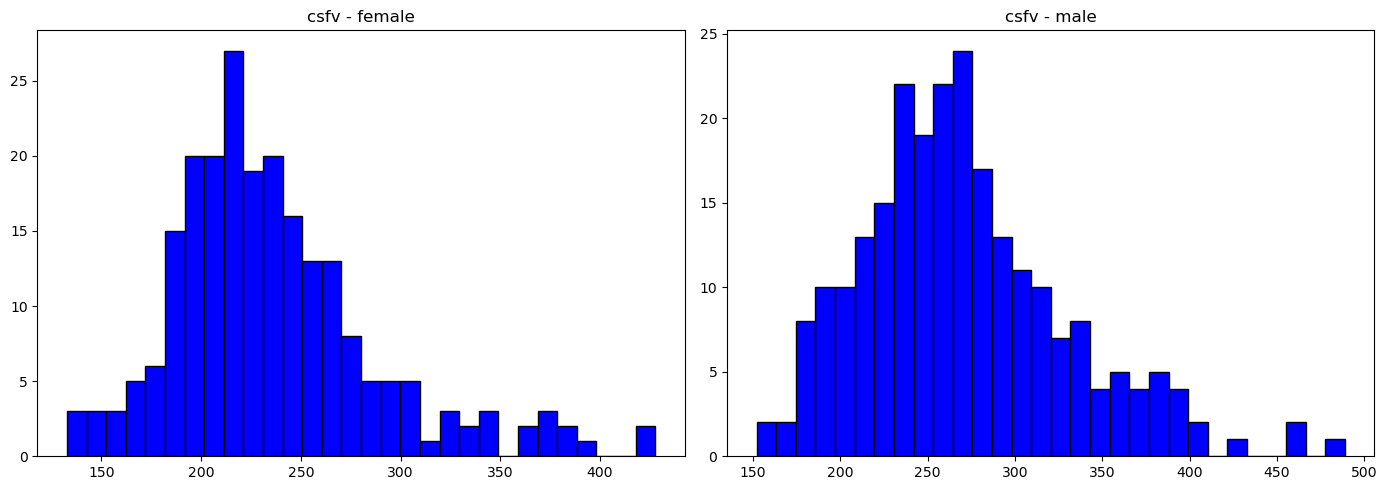

Comparing numerical column: ***wmv***
 Female mean: 479.128 | female std: 50.23 ## Male mean: 546.013 | male std: 61.63


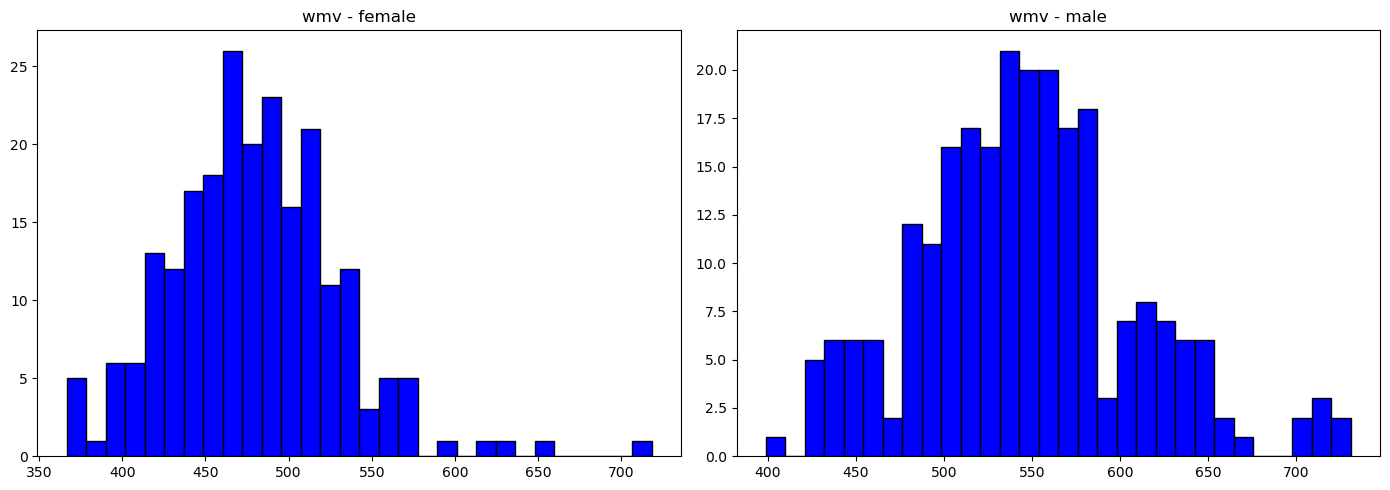

Comparing numerical column: ***gmv***
 Female mean: 643.915 | female std: 75.06 ## Male mean: 730.284 | male std: 80.21


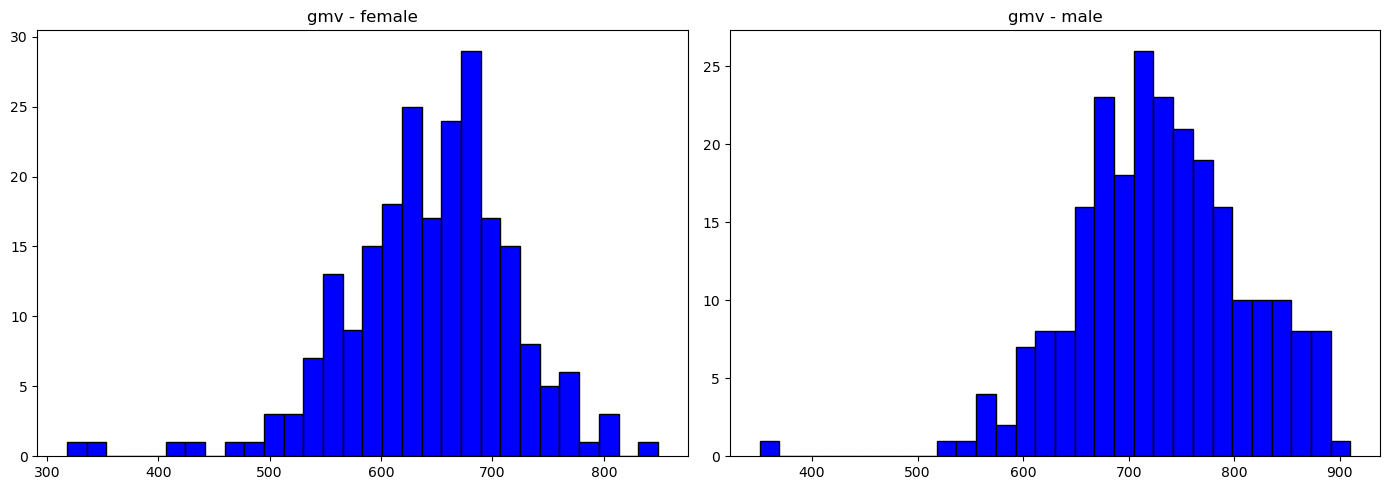

In [225]:
# Analyse numerical data

def analyse_numerical_column_compare_sexes(col:str, df: pd.DataFrame)-> None:
    female_df = df[df["sex"] == "female"]
    male_df = df[df["sex"] == "male"]
    print(f"Comparing numerical column: ***{col}***")
    female_mean = female_df[col].mean()
    female_std = female_df[col].std()
    male_mean = male_df[col].mean()
    male_std = male_df[col].std()
    print(f" Female mean: {female_mean:.3f} | female std: {female_std:.2f} ## Male mean: {male_mean:.3f} | male std: {male_std:.2f}")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # Plot col distribution for females
    axes[0].hist(female_df[col], bins=30, color='blue', edgecolor='black')
    axes[0].set_title(col + " - female")

    # Plot col distribution for males
    axes[1].hist(male_df[col], bins=30, color='blue', edgecolor='black')
    axes[1].set_title(col + " - male")

    # Display the plots
    plt.tight_layout()
    plt.show()

volume_cols = ["csfv", "wmv", "gmv"]
for col in volume_cols:
    analyse_numerical_column_compare_sexes(col, train_meta_df)


After finding out there is only 1-2 examples with low tiv, I wanted to see which patience has these outlier values

In [19]:
low_tiv = train_meta_df[train_meta_df["tiv"] < 900]
low_tiv.head()

participant_id study     sex   age  site diagnosis         tiv  \
432   222716353013     6  female  25.0  52.0   control  872.171976   

           csfv         gmv         wmv  magnetic_field_strength  \
432  141.051929  318.006349  411.831325                      3.0   

     acquisition_setting  age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  
432                  1.0         25             (20, 30]       (20, 30]

<Axes: >

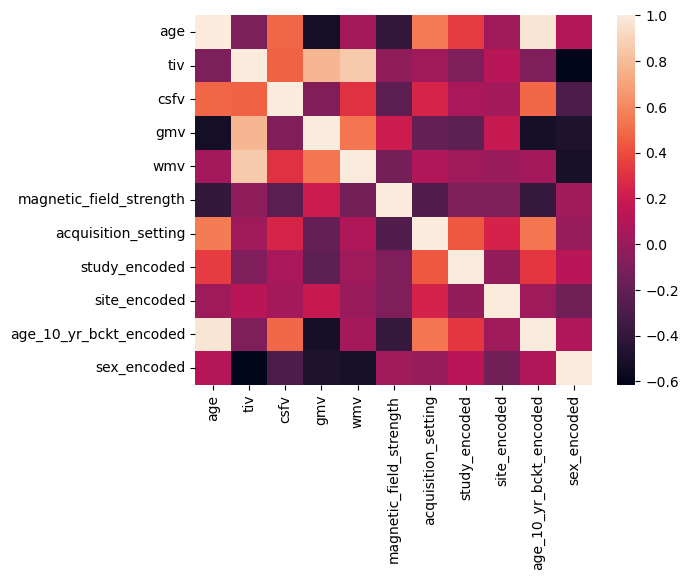

In [20]:
# To create a correlation map between the different feature, first encode all categorical features
import seaborn as sns

## Encoding categorical data to create a correlation hitmap
df_data_for_corr_matrix = train_meta_df.copy()
df_data_for_corr_matrix["study_encoded"] = df_data_for_corr_matrix.apply(lambda x: int(x["study"]), axis=1)
df_data_for_corr_matrix["site_encoded"] = df_data_for_corr_matrix.apply(lambda x: float(x["site"]), axis=1)
df_data_for_corr_matrix["age_10_yr_bckt_encoded"] = df_data_for_corr_matrix.apply(lambda x: x["age"] // 10, axis=1)
df_data_for_corr_matrix["sex_encoded"] = df_data_for_corr_matrix.apply(lambda x: 1.0 if x["sex"] == "female" else 0.0, axis=1)

# For the correlation matrix to be concise, remove the data that is less 
df_data_for_corr_matrix.drop(columns=["age_10_yr_bckt_bg_70", "diagnosis", "age_10_yr_bckt", "study", "site", "sex", "age_round", "participant_id"], inplace=True)

sns.heatmap(df_data_for_corr_matrix.corr())


🚧 **Exercise 1.2** 🚧

In the code block below, add: 
* ```train_prop```: The proportion of the train data that you will assign to training the model (where the remaining will be used for validation)
* ```stratification_variables```: Whether you intend to stratify by any variables when creating the train/validation split
* ```test_metric```: The metric you intend to use to assess performance on the test set

(Stratified sampling is a technique used to ensure that the subsets of the data (in this case, training, validation, and test sets) are representative of the whole dataset. This is especially important in cases where the dataset is not homogeneous and contains distinct groups that should be evenly represented in each set.)

In [17]:
# Exercise: input answer here
from sklearn import metrics 
# Your code here
train_prop = 0.80
stratification_variables = ["sex", "age_10_yr_bckt_bg_70"] # a list of variables from the meta data, e.g. ["variable_1", "variable_2"]. Ensure you choose at least one variable, or the code will not run!
test_metric = metrics.mean_absolute_error # This is not used later in the notebook, but it is good to decide it now
# Your code here - END

The code below defines three numpy arrays ```train_pats```, ```val_pats``` and ```test_pats``` containing a (potentially stratified) random selection of patient ids assigned to the respective datasets.

In [18]:
grp_df = train_meta_df.groupby(by=stratification_variables)
train_pats = []
val_pats = []
test_pats = []
for idx, grp in grp_df:
    train, val = np.split(
        grp["participant_id"], 
        [
            int(np.floor(grp.shape[0]*train_prop))
        ]
    )
    train_pats.append(train) 
    val_pats.append(val)
train_pats = np.concatenate(train_pats)
val_pats = np.concatenate(val_pats)
test_pats = test_meta_df["participant_id"].values

with open(os.path.join(TRAIN_DIR, "train_pats.pkl"), "wb") as f:
    pickle.dump(train_pats, f)

with open(os.path.join(TRAIN_DIR, "val_pats.pkl"), "wb") as f:
    pickle.dump(val_pats, f)

with open(os.path.join(TEST_DIR, "test_pats.pkl"), "wb") as f:
    pickle.dump(test_pats, f)

print(f"Num training patients: {len(train_pats)}")
print(f"Num validation patients: {len(val_pats)}")
print(f"Num testing patients: {len(test_pats)}")

Num training patients: 365
Num validation patients: 101
Num testing patients: 167


## Part 2: Baseline model definition

Now the model development assumptions have been defined, a baseline model needs to be developed. This baseline model should act as a spring board for your subsequent model development. Ideally should balance the following objectives:
* Attain a __reasonable__ level of performance, and;
* Be __simple__! This is almost the most important requirement since if the model is too complex, understanding which areas of the archtecture are underperforming will be challenging!


In this exercise the baseline model should be defined by the following pipeline:

1. **Volume prediction:** A deep learning model is trained to take in patient MRI images and predict three patient brain volume values (explained in more detail below).
2. **MLP Regression:** A multi-layer perceptron regression model takes patient brain volume values as input and predicts patient age.

These models will be trained seperately, then combined to make end-to-end MRI -> age predictions at test time. We elaborate more on the motivation behind this pipeline below.

__Your main task__ will be to define the deep learning Volume Prediction model and subsequently justify and explain your design choices. 

_Hints_:
* What might be a 'simple' go-to deep learning architecture for processing images?
* Do 3D images need to be treated differently to 2D images (see Pytorch [CONV3D](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html#conv3d)...)
* How might 'reasonable' be defined?
    * Does the baseline perform better than random chance?
    * Does the baseline perform better than just applying a linear regression or xgBoost model directly on the images?
* As this is a baseline, performance is not expected to be excellent. As you are only expected to implement the volume predictor, it is ok if other parts of the pipline are limiting. However, you may make small modifications to the mlp training, etc. to ensure reasonable performance.

### Data Helpers

Before we begin, lets load and process the data.

In [19]:
def zero_mean_unit_var(
    img_array:np.array
    )->np.array:
    """Function to normalise an input image to have 0 mean and unit variance

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan

    Returns:
        np.array: Normalised version of img_array
    """
    mean = np.mean(img_array)
    std = np.std(img_array)
    # Capture 0 values as these are background
    zero_values = img_array == 0
    if std > 0:
        img_array = (img_array - mean) / std
        img_array[zero_values] = 0
    return img_array


def resample_image(
    img_array:np.array, 
    out_spacing:Tuple[float]=(1.0, 1.0, 1.0), 
    out_size:Tuple[float]=None, 
    is_label:bool=False, 
    pad_value=0
    )->np.array:
    """Function to alter the proportions of an input image represented as a 
    numpy array  

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan
        out_spacing (Tuple[float], optional): ???. Defaults to (1.0, 1.0, 1.0).
        out_size (Tuple[float], optional): Tuple of length 3 defining the 
        desired output dimensions of the image. Defaults to None.
        is_label (bool, optional): ???. Defaults to False.
        pad_value (int, optional): ???. Defaults to 0.

    Returns:
        np.array: _description_
    """
    
    image = sitk.GetImageFromArray(img_array)
    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return sitk.GetArrayFromImage(resample.Execute(image))

We will create seperate dataloaders for the volume prediction task and the linear regression task.

First, we create the volume prediction data loaders. This data loader provides a batch of 3D MRI images as 'X', and the corresponding brain volume labels as 'y'. The train/val/test splits you decided previously will be used.

In [20]:
class VolumePredictionDataset(Dataset):
    '''
    Important: By default, this dataset returns normalized versions of the input MRI images and output volume labels.
    '''
    
    def __init__(
        self, 
        patient_list:List[str], 
        mri_file_dir:str,
        meta_df:pd.DataFrame,
        volume_norm_stats:Dict[str,np.array],
        target_1_col = "csfv",
        target_2_col = "gmv",
        target_3_col = "wmv",
        out_spacing = OUT_SPACING, 
        out_size = OUT_SIZE,
    ):
        self.samples:List[Dict[str,torch.tensor]] = []
        
        for pat in tqdm(patient_list, desc='Loading Data'):
            
            # MRI image
            X = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X = zero_mean_unit_var(X)
            if (out_spacing is not None) and (out_size is not None):
                X = resample_image(X, out_spacing=out_spacing, out_size=out_size)
            X = torch.from_numpy(X).unsqueeze(0).to(torch.float32)
            
            # Volume labels
            y = meta_df[meta_df["participant_id"] == pat][[target_1_col, target_2_col, target_3_col]].values.squeeze()
            y = (y-volume_norm_stats['mean'])/volume_norm_stats['std']
            y = torch.from_numpy(y).float()
            
            sample = {'X': X,  "y":y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

**Data normalization:**

In our datasets, we will normalize both the input and the output data for model training. Images are simply normalized to each have zero mean and unit variance. Volumes and ages are normalized using statistics of the train dataset, calculated below.

In [21]:
# Normalization stats

age_norm_stats = {
    'mean': train_meta_df["age"].mean(axis=0),
    'std': train_meta_df["age"].std(axis=0)
}

volume_norm_stats = {
    'mean': train_meta_df[["csfv", "gmv", "wmv"]].mean(axis=0).values,
    'std': train_meta_df[["csfv", "gmv", "wmv"]].std(axis=0).values
}

print("age norm stats")
display(age_norm_stats)

print("volume norm stats")
display(volume_norm_stats)

age norm stats


{'mean': 24.730252048494517, 'std': 13.336105435557245}

volume norm stats


{'mean': array([253.44248979, 688.5824933 , 513.71863709]),
 'std': array([58.58350478, 88.89055568, 65.53866211])}

In [103]:
# Expect this cell to take 8 mins
rnd_seed = 42
batch_size = 8 # Can be changed if you wish
torch.manual_seed(rnd_seed)

vol_train_data = VolumePredictionDataset(
    patient_list=train_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)

vol_train_loader = DataLoader(vol_train_data, batch_size=batch_size)

vol_val_data = VolumePredictionDataset(
    patient_list=val_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)

vol_val_loader = DataLoader(vol_val_data, batch_size=batch_size)

vol_test_data = VolumePredictionDataset(
    patient_list=test_pats, 
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df,
    volume_norm_stats=volume_norm_stats,
)

tmp = next(vol_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")

Loading Data:   0%|          | 0/365 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 167/167 [01:31<00:00,  1.83it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([8, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([8, 3])


Ensure you understand what the inputs and outputs represent, and what each axis of the data represents.

Next, we define the data loaders for the MLP age regression task. These return brain volumes as 'X' and age labels as 'y'.

In [47]:
class AgeRegressionDataset(Dataset):
    '''
    Important:
    - By default, this dataset returns normalized versions of the input volumes and output age labels.
    '''
    
    def __init__(
        self, 
        patient_list:List[str],
        meta_df:pd.DataFrame,
        volume_norm_stats:Dict[str,np.array],
        age_norm_stats:Dict[str,np.array],
        x_1_col = "csfv",
        x_2_col = "gmv",
        x_3_col = "wmv",
    ):  
        self.samples:List[Dict[str,torch.tensor]] = []
        
        for pat in tqdm(patient_list, desc='Loading Data'):
            
            # Brain volumes
            X = meta_df[meta_df["participant_id"] == pat][[x_1_col, x_2_col, x_3_col]].values.squeeze()
            X = (X-volume_norm_stats['mean'])/volume_norm_stats['std']
            X = torch.from_numpy(X).float()
            
            # Ages
            y = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y = (y-age_norm_stats['mean'])/age_norm_stats['std']
            y = torch.tensor(y).float()
            
            sample = {'X': X,  "y":y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

In [48]:
rnd_seed = 42
batch_size = 2
torch.manual_seed(rnd_seed)

mlp_train_data = AgeRegressionDataset(
    patient_list=train_pats,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
    age_norm_stats=age_norm_stats,
)
mlp_train_loader = DataLoader(mlp_train_data, batch_size=batch_size)

mlp_val_data = AgeRegressionDataset(
    patient_list=val_pats,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
    age_norm_stats=age_norm_stats,
)
mlp_val_loader = DataLoader(mlp_val_data, batch_size=batch_size)

tmp = next(mlp_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (csfv, gmv, wmv brain volumes) dimensions are: {tmp['X'].shape}")
print(f"The output (patient age) dimensions are: {tmp['y'].shape}")

for example in tmp['X']:
    print(example)

Loading Data:   0%|          | 0/365 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 101/101 [00:00<00:00, 541.91it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([2, 3])
The output (patient age) dimensions are: torch.Size([2])
tensor([-1.4179, -0.4927, -1.7670])
tensor([ 0.6246,  0.8832, -0.8132])


Again, ensure you understand what the inputs and outputs represent, and what each axis of the data represents.

### Motivating the baseline model pipeline

Our training dataset provides ground-truth information about patient brain volumes, namely:
- csfv: Cerebrospinal fluid volume
- gmv: Grey matter volume
- wmv: White matter volume

It has been found previously that these brain volumes are correlated with age. Lets investigate if that is the case in our dataset. If so, these values could be useful for our task of predicting brain age!


In [49]:
# Get ages
ages = train_meta_df["age"].values

# Get volumes
volumes = train_meta_df[["csfv", "gmv", "wmv"]].values
csfv = volumes[:,0]
gmv = volumes[:,1]
wmv = volumes[:,2]

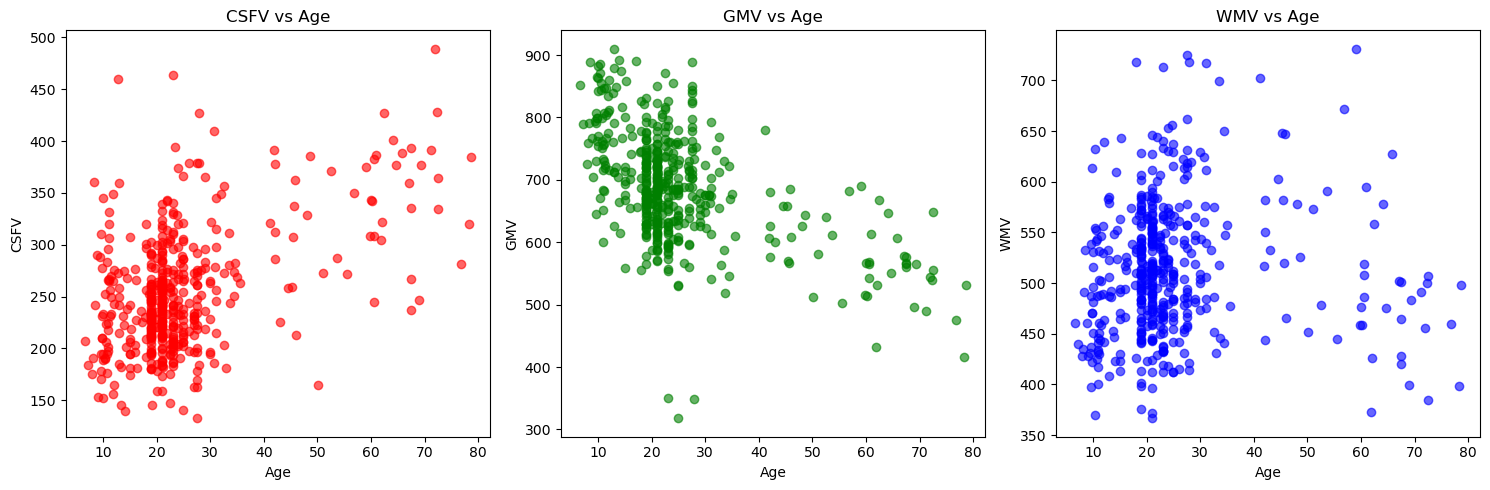

In [50]:
# Create scatter plots to visualize the correlation between volumes and age

import matplotlib.pyplot as plt

# Create a figure and a 1x3 subplot (for 3 plots in a row)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot csfv vs age
axes[0].scatter(ages, csfv, color='r', alpha=0.6)
axes[0].set_title('CSFV vs Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('CSFV')

# Plot gmv vs age
axes[1].scatter(ages, gmv, color='g', alpha=0.6)
axes[1].set_title('GMV vs Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('GMV')

# Plot wmv vs age
axes[2].scatter(ages, wmv, color='b', alpha=0.6)
axes[2].set_title('WMV vs Age')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('WMV')

# Display the plots
plt.tight_layout()
plt.show()

We see some visual evidence here that age is correlated with the brain volumes. This means the brain volume information may be useful for predicting age. 

Thus, we may be able to split our baseline model into two parts: (i) Volume Prediction Model: a deep learning model that predicts brain volumes from MRI images; and (ii) MLP Regression Model: a multi-layer perceptron regression model that predicts age from brain volumes.

Note, this approach leverages the brain volume information available to in the training data, but will not require any ground-truth brain volume information at deplyoment! (At training, the Linear Regression Model will be trained to map from ground-truth volumes to age. But at deployment it will take volume values predicted by the Volume Prediction Model).

### Baseline: MLP Regression training

First lets train the MLP regression model.

Lets define some standard training and testing functions.

(**Optional Exercise**: You may modify these training and testing functions if you wish to add more sophisticated logging)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    
    total_loss = 0
    for step, data in enumerate(dataloader):
        X, y = data['X'].to(device), data['y'].to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    average_loss = total_loss / num_batches
    print(f"Train loss: {average_loss:>7f}")
    return average_loss

In [52]:
def test(dataloader, model, loss_fn, y_norm_stats):
    def denorm(y):
        return y.cpu() * y_norm_stats['std'] + y_norm_stats['mean']
    
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, mae_loss = 0, 0
    with torch.no_grad():
        for data in dataloader:
            X, y = data['X'].to(device), data['y'].to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            mae_loss += torch.mean(torch.abs(denorm(pred) - denorm(y))).item()
    
    test_loss /= num_batches
    mae_loss /= num_batches
    print(f"Test loss: {test_loss:>8f}, MAE: {mae_loss:>8f}\n")
    return test_loss

Now define the linear regression model in pytorch.

In [84]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
tmp = next(mlp_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]
print(tmp['X'])
print(tmp['X'].shape)

mlp_model_base = MLPRegression(in_shape[0]).float().to(device)

output = mlp_model_base(tmp['X'].to(device))
print("MLP Regression Model output shape: ", output.shape)

tensor([[-1.4179, -0.4927, -1.7670],
        [ 0.6246,  0.8832, -0.8132]])
torch.Size([2, 3])
MLP Regression Model output shape:  torch.Size([2, 1])


Now train the lmlp regression model

In [85]:
mlp_loss_fn = nn.MSELoss()
mlp_optimizer = torch.optim.Adam(mlp_model_base.parameters(), lr=1e-3)

Epoch 1
-------------------------------
Train loss: 0.794959
Test loss: 0.911213, MAE: 9.068277

Epoch 2
-------------------------------
Train loss: 0.679259
Test loss: 0.712905, MAE: 7.761738

Epoch 3
-------------------------------
Train loss: 0.615601
Test loss: 0.647499, MAE: 7.401013

Epoch 4
-------------------------------
Train loss: 0.591820
Test loss: 0.619575, MAE: 7.241615

Epoch 5
-------------------------------
Train loss: 0.576504
Test loss: 0.603202, MAE: 7.151109

Epoch 6
-------------------------------
Train loss: 0.565194
Test loss: 0.594030, MAE: 7.090793

Epoch 7
-------------------------------
Train loss: 0.556156
Test loss: 0.586953, MAE: 7.034057

Epoch 8
-------------------------------
Train loss: 0.548815
Test loss: 0.582372, MAE: 6.986618

Epoch 9
-------------------------------
Train loss: 0.543126
Test loss: 0.579542, MAE: 6.950015

Epoch 10
-------------------------------
Train loss: 0.537097
Test loss: 0.577078, MAE: 6.916039

Done!


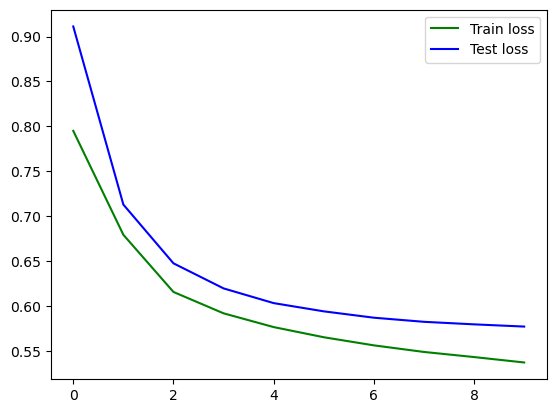

In [86]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(mlp_train_loader, mlp_model_base, mlp_loss_fn, mlp_optimizer))
    test_losses.append(test(mlp_val_loader, mlp_model_base, mlp_loss_fn, age_norm_stats))
print("Done!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.legend()
plt.show()


If all has gone well, you should see the loss decreasing on both the train and validation data

Lets check some predictions to visually inspect the models accuracy.

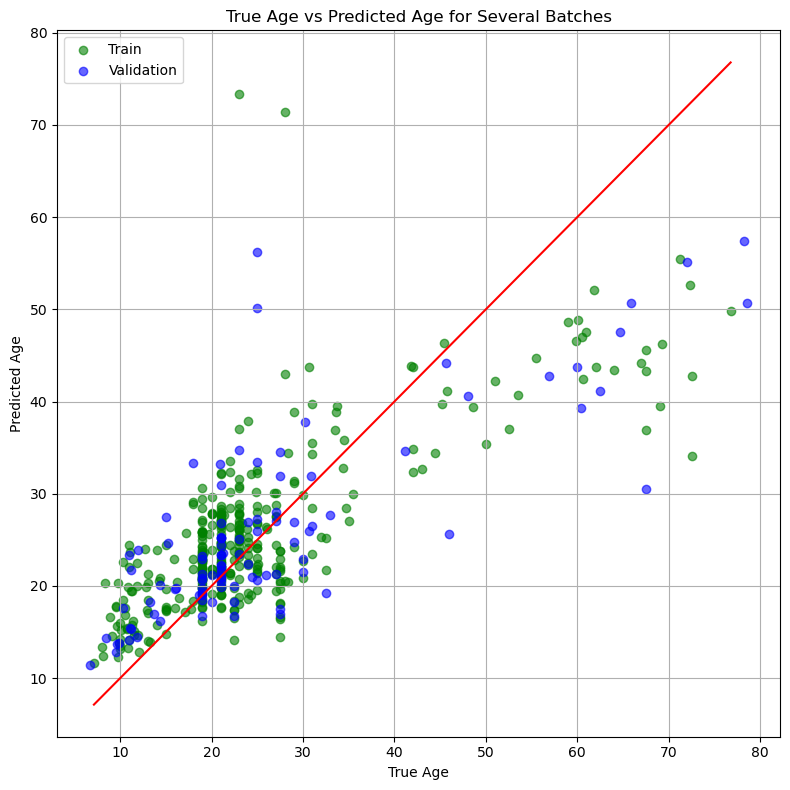

In [233]:
def get_true_and_predicted_arrays(data_loader, model, norm_stats):
    true_ages_list = []
    predicted_ages_list = []

    # Loop through the loader for a certain number of batches (e.g., 10 batches in this example)
    for i, batch in enumerate(data_loader):
        with torch.no_grad():
            inputs = batch['X'].to(device)
            true_ages = batch['y'].cpu().numpy().reshape(-1)
            predicted_ages = model(inputs).detach().cpu().numpy().reshape(-1)
        true_ages_list.extend(true_ages)
        predicted_ages_list.extend(predicted_ages)

    # denormalize the true ages
    true_ages_list = np.array(true_ages_list) * norm_stats['std'] + norm_stats['mean']
    predicted_ages_list = np.array(predicted_ages_list) * norm_stats['std'] + norm_stats['mean']  
    return true_ages_list, predicted_ages_list 

# denormalize the true ages
    
true_ages_train, predicted_ages_train = get_true_and_predicted_arrays(mlp_train_loader, mlp_model_base, age_norm_stats)
true_ages_val, predicted_ages_val = get_true_and_predicted_arrays(mlp_val_loader, mlp_model_base, age_norm_stats)

# true_ages_list = np.array(true_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']
# predicted_ages_list = np.array(predicted_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']

plt.figure(figsize=(8, 8))
plt.scatter(true_ages_train, predicted_ages_train, alpha=0.6, color="green", label="Train")
plt.scatter(true_ages_val, predicted_ages_val, alpha=0.6, color="blue", label="Validation")
plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_train), max(true_ages_train)], [min(true_ages_train), max(true_ages_train)], color='red')  # Line of best fit
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Baseline: Deep Neural Network Brain Volume Prediction

Now you must define and train your volume prediction model!

🚧 **Exercise 2.1** 🚧

Define the volume prediction model.

In [104]:
class VolumePredictor(nn.Module):
    def __init__(self, in_shape, out_size):
        super(VolumePredictor, self).__init__()
        ##################
        # Your code here #
        ##################
        self.conv_relu_pool_stack = nn.Sequential(
            # Layer 1
            nn.Conv3d(in_channels=1, out_channels=1, kernel_size=5),
            nn.LeakyReLU(0.0001),
            nn.AvgPool3d(2),
        )
        self.flatten = nn.Flatten()
        self.out_layer = nn.Linear(46*46*46, 3)

    def forward(self, x):
        ##################
        # Your code here #
        ##################
        # print(f"got x with shape {x.shape}")
        x = self.conv_relu_pool_stack(x)
        # print(f"after conv layers, shape of x is {x.shape}")
        x = self.flatten(x)
        # print(f"after flatten, shape of x is: {x.shape}")
        x = self.out_layer(x)
        # print(f"after out layer, shape of x is: {x.shape}")
        return x

#### Train volume prediction model

In [111]:
# Define model and run a batch through the model to check it works
torch.manual_seed(rnd_seed)
tmp = next(vol_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]

vol_model_leaky_base_early_stop = VolumePredictor(in_shape, out_size).float().to(device)

input = tmp['X'].to(device)
output = vol_model_leaky_base_early_stop(input)
print(output.shape)

torch.Size([8, 3])


In [112]:
# Leaky Relu 0.0001 early stop
vol_loss_fn = nn.MSELoss()
vol_leaky_early_stop_optimizer = torch.optim.Adam(vol_model_leaky_base_early_stop.parameters(), lr=5*1e-4)

Epoch 1
-------------------------------
Train loss: 0.916518
Test loss: 1.229642, MAE: 62.248478

Epoch 2
-------------------------------
Train loss: 1.012945
Test loss: 1.205761, MAE: 59.504946

Epoch 3
-------------------------------
Train loss: 0.852574
Test loss: 1.238697, MAE: 61.826666

Epoch 4
-------------------------------
Train loss: 0.875135
Test loss: 1.134730, MAE: 57.977450

Epoch 5
-------------------------------
Train loss: 0.674257
Test loss: 1.314482, MAE: 63.323399

Epoch 6
-------------------------------
Train loss: 0.698890
Test loss: 1.050610, MAE: 56.304852

Epoch 7
-------------------------------
Train loss: 0.485618
Test loss: 1.169449, MAE: 60.089105

Epoch 8
-------------------------------
Train loss: 0.403334
Test loss: 1.170737, MAE: 59.541522

Epoch 9
-------------------------------
Train loss: 0.299152
Test loss: 1.175229, MAE: 59.759884

Epoch 10
-------------------------------
Train loss: 0.212693
Test loss: 1.116619, MAE: 56.868695

Epoch 11
----------

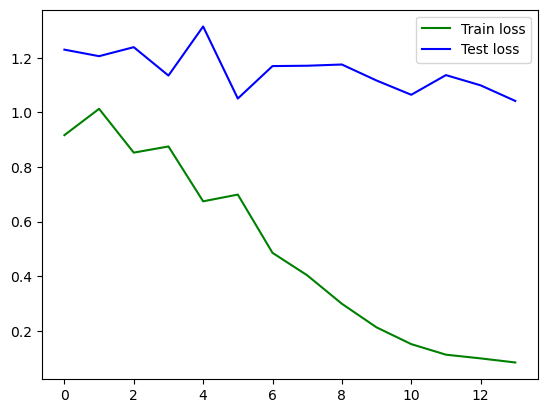

In [113]:
epochs = 14
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(vol_train_loader, vol_model_leaky_base_early_stop, vol_loss_fn, vol_leaky_early_stop_optimizer))
    test_losses.append(test(vol_val_loader, vol_model_leaky_base_early_stop, vol_loss_fn, volume_norm_stats))
print("Done!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.legend()
plt.show()

In [396]:
MODEL_DIR = "models"
with open(os.path.join(MODEL_DIR, "vol_model_baseline.pkl"), "wb") as f:
    pickle.dump(vol_model_leaky_base_early_stop, f)

In [172]:
def get_true_and_predicted_volumes(model, data_loader, norm_stats=volume_norm_stats):
    true_csfv_list = []
    predicted_csfv_list = []

    true_gmv_list = []
    predicted_gmv_list = []

    true_wmv_list = []
    predicted_wmv_list = []

    # Loop through the train loader 🚧 Exercise: Is the train data the best dataset to use to visualize model performance here? 🚧
    ## Answer: For visualization of the model's performance, it is better to look at the validation set than on the test set.
    ## If a model performs perfectly on train set, it could either mean that it has great performance, or that it is over fitted to this 
    ## specific training set. Therefore, validation set is more 
    for batch in data_loader:
        with torch.no_grad():
            inputs = batch['X'].to(device)
            true_volumes = batch['y'].cpu().numpy()
            
            # Predict volumes
            predicted_volumes = model(inputs).detach().cpu().numpy()
            
            # Denormalize predicted volumes and true volumes
            predicted_volumes = predicted_volumes * norm_stats['std'] + norm_stats['mean']
            true_volumes = true_volumes * norm_stats['std'] + norm_stats['mean']
            
            # Append true and predicted volumes to the respective lists
            true_csfv_list.extend(true_volumes[:, 0])
            predicted_csfv_list.extend(predicted_volumes[:, 0])
            
            true_gmv_list.extend(true_volumes[:, 1])
            predicted_gmv_list.extend(predicted_volumes[:, 1])
            
            true_wmv_list.extend(true_volumes[:, 2])
            predicted_wmv_list.extend(predicted_volumes[:, 2])
        
        # Convert lists to numpy arrays
    true_csfv_array = np.array(true_csfv_list)
    predicted_csfv_array = np.array(predicted_csfv_list)

    true_gmv_array = np.array(true_gmv_list)
    predicted_gmv_array = np.array(predicted_gmv_list)

    true_wmv_array = np.array(true_wmv_list)
    predicted_wmv_array = np.array(predicted_wmv_list)

    return  true_csfv_array, predicted_csfv_array, true_gmv_array, predicted_gmv_array, true_wmv_array, predicted_wmv_array

def plot_vol_predictions(model, train_data_loader, val_data_loader, norm_stats=volume_norm_stats):
    train_true_csfv_array, train_predicted_csfv_array, train_true_gmv_array, train_predicted_gmv_array, train_true_wmv_array, train_predicted_wmv_array = get_true_and_predicted_volumes(model, train_data_loader, norm_stats)
    val_true_csfv_array, val_predicted_csfv_array, val_true_gmv_array, val_predicted_gmv_array, val_true_wmv_array, val_predicted_wmv_array = get_true_and_predicted_volumes(model, val_data_loader, norm_stats)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot true vs predicted volumes for csfv
    axes[0].scatter(train_true_csfv_array, train_predicted_csfv_array, alpha=0.6, color="green")
    axes[0].scatter(val_true_csfv_array, val_predicted_csfv_array, alpha=0.6, color="blue")
    axes[0].plot([min(train_true_csfv_array), max(train_true_csfv_array)], [min(train_true_csfv_array), max(train_true_csfv_array)], color='red')
    axes[0].set_title('True CSFV vs Predicted CSFV')
    axes[0].set_xlabel('True CSFV')
    axes[0].set_ylabel('Predicted CSFV')
    axes[0].grid(True)

    # Plot true vs predicted volumes for gmv
    axes[1].scatter(train_true_gmv_array, train_predicted_gmv_array, alpha=0.6, color="green")
    axes[1].scatter(val_true_gmv_array, val_predicted_gmv_array, alpha=0.6, color="blue")
    axes[1].plot([min(train_true_gmv_array), max(train_true_gmv_array)], [min(train_true_gmv_array), max(train_true_gmv_array)], color='red')
    axes[1].set_title('True GMV vs Predicted GMV')
    axes[1].set_xlabel('True GMV')
    axes[1].set_ylabel('Predicted GMV')
    axes[1].grid(True)

    # Plot true vs predicted volumes for wmv
    axes[2].scatter(train_true_wmv_array, train_predicted_wmv_array, alpha=0.6, color="green")
    axes[2].scatter(val_true_wmv_array, val_predicted_wmv_array, alpha=0.6, color="blue")
    axes[2].plot([min(train_true_wmv_array), max(train_true_wmv_array)], [min(train_true_wmv_array), max(train_true_wmv_array)], color='red')
    axes[2].set_title('True WMV vs Predicted WMV')
    axes[2].set_xlabel('True WMV')
    axes[2].set_ylabel('Predicted WMV')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

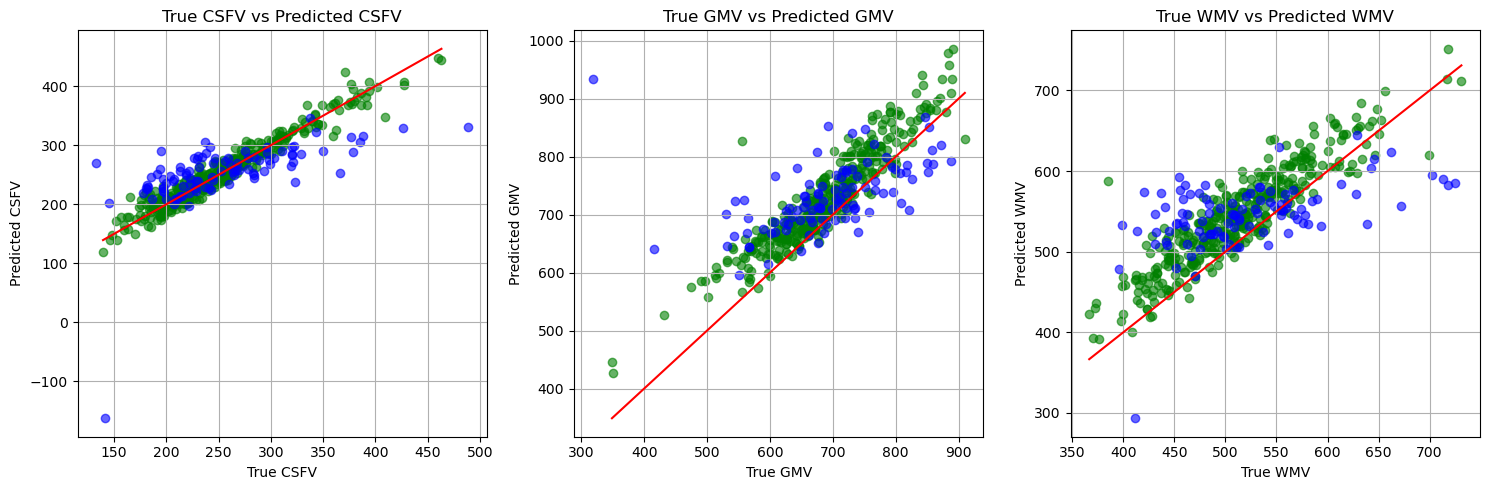

In [116]:
plot_vol_predictions(model=vol_model_leaky_base_early_stop, train_data_loader=vol_train_loader, val_data_loader=vol_val_loader, norm_stats=volume_norm_stats)

**Optional Exercise:** Feel free to modify the training loop, training parameters, etc, if there is anything you wish to improve

### Baseline: Combine models to attain end-to-end predictions

Finally, we will combine the deep learning volume prediction model with the MLP regression model to obtain end-to-end predictions of age from MRI images.

Define the end-to-end validation dataset and data loaders:

In [117]:
class EndToEndDataset(Dataset):
    
    def __init__(
        self, 
        patient_list:List[str], 
        mri_file_dir:str,
        meta_df:pd.DataFrame,
        ages_norm_stats:Dict[str,np.array],
        out_spacing = OUT_SPACING, 
        out_size = OUT_SIZE,
    ):
        self.samples:List[Dict[str,torch.tensor]] = []
        
        for pat in tqdm(patient_list, desc='Loading Data'):
            
            # MRI images
            X = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X = zero_mean_unit_var(X)
            if (out_spacing is not None) and (out_size is not None):
                X = resample_image(X, out_spacing=out_spacing, out_size=out_size)
            X = torch.from_numpy(X).unsqueeze(0).float()
            
            # Ages
            y = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y = (y-ages_norm_stats['mean'])/ages_norm_stats['std']
            y = torch.tensor(y).unsqueeze(0).float()
            
            sample = {'X': X,  "y":y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

In [91]:
e2e_val_data = EndToEndDataset(
    patient_list=val_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    ages_norm_stats=age_norm_stats,
)

e2e_val_loader = DataLoader(e2e_val_data, batch_size=2)

tmp = next(e2e_val_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input dimensions are: {tmp['X'].shape}")
print(f"The output dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 101/101 [00:55<00:00,  1.81it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input dimensions are: torch.Size([2, 1, 96, 96, 96])
The output dimensions are: torch.Size([2, 1])


In [199]:
e2e_train_data = EndToEndDataset(
    patient_list=train_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    ages_norm_stats=age_norm_stats,
)

e2e_train_loader = DataLoader(e2e_train_data, batch_size=2)

Loading Data: 100%|██████████| 365/365 [03:28<00:00,  1.75it/s]


Define the combined model:

In [162]:
class CombinedModel(nn.Module):
    def __init__(self, volume_predictor, age_regressor):
        super(CombinedModel, self).__init__()
        self.volume_predictor = volume_predictor
        self.age_regressor = age_regressor

    def forward(self, x):
        x = self.volume_predictor(x)
        return self.age_regressor(x)

In [163]:
combined_model = CombinedModel(vol_model_leaky_base_early_stop, mlp_model_base).float().to(device)

tmp = next(e2e_val_loader.__iter__())
output = combined_model(tmp['X'].to(device))

Assess performance of end-to-end model on the validation data:

In [164]:
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model, e2e_loss_fn, age_norm_stats)

Test loss: 1.089519, MAE: 8.364075



1.0895185214832572

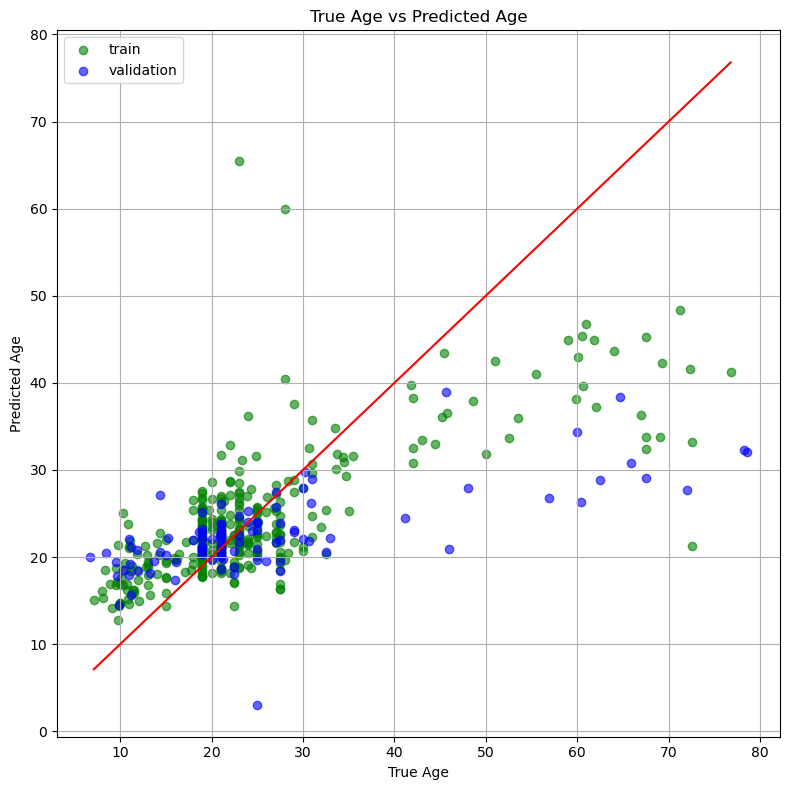

In [200]:
true_train, predicted_train = get_true_and_predicted_arrays(e2e_train_loader, combined_model, age_norm_stats)
true_val, predicted_val = get_true_and_predicted_arrays(e2e_val_loader, combined_model, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_train, predicted_train, alpha=0.6, color="green", label="train")
plt.scatter(true_val, predicted_val, alpha=0.6, color="blue", label="validation")

plt.title('True Age vs Predicted Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_train), max(true_train)], [min(true_train), max(true_train)], color='red')  # Line of best fit
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

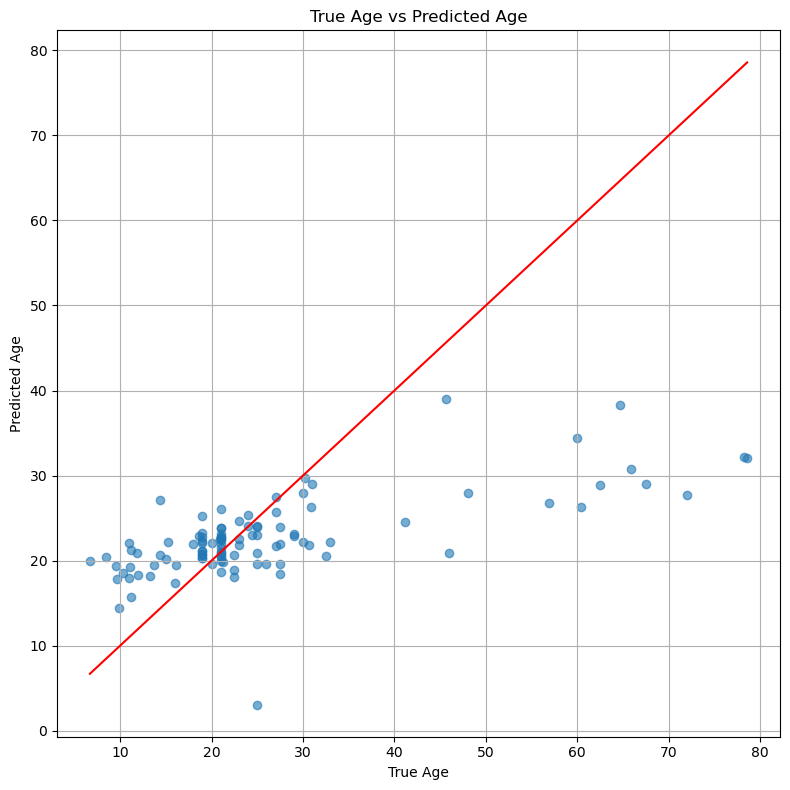

In [121]:
true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches of the validation data (e.g., 10 batches in this example)
for i, batch in enumerate(e2e_val_loader):
    with torch.no_grad():
        inputs = batch['X'].to(device)
        true_ages = batch['y'].cpu().numpy().reshape(-1)
        predicted_ages = combined_model(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# denormalize the true ages
true_ages_list = np.array(true_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']
predicted_ages_list = np.array(predicted_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']

plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title('True Age vs Predicted Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

#### 🚧 **Exercise 2.2** 🚧

Analyse you results and consider writting about the following in your report:

- Justification for your volume prediction model structure/design
- Discussion of results from volume prediction model
- Discussion of results from the MLP regression model
- Discusion of results from end-to-end combined model
- Discussion of reasonability of performance (and what the limitations may be and why)

You should provide evidence to backup your discussions and any conclusions. This may include showing performance on held out validation/test sets (using the metrics you chose previously), and other statistical tests or visualisations. You do not have to limit yourself to the visualisations/analysis already implemented in the notebook!

<Insert report here>

Note: The answer to the question is in the report. Attached here is the code I used to support the my answer in the report. 


The code below is written to compare the volume prediction model above to basic methods, in order to understand whether it is reasonable or not 



**1. basic linear regression on the MRIs**

torch.Size([1, 96, 96, 96])
3
torch.Size([8, 3])
Epoch 1
-------------------------------
Train loss: 113.503545
Test loss: 2.516343, MAE: 16.678320

Epoch 2
-------------------------------
Train loss: 6.116708
Test loss: 2.821444, MAE: 18.880549

Epoch 3
-------------------------------
Train loss: 4.269692
Test loss: 1.703192, MAE: 14.077740

Epoch 4
-------------------------------
Train loss: 2.543182
Test loss: 1.141769, MAE: 11.088324

Epoch 5
-------------------------------
Train loss: 1.892824
Test loss: 1.039815, MAE: 10.485066

Done!


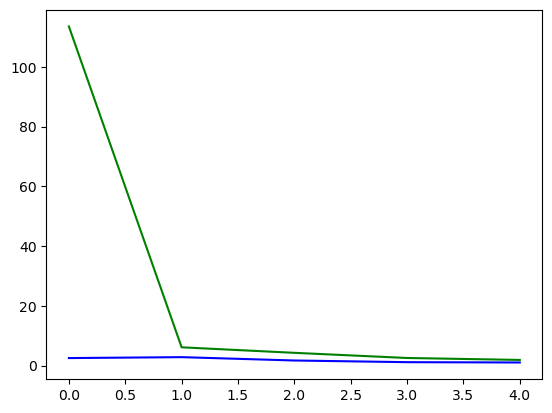

In [ ]:
class VolumePredictorLinearRegression(nn.Module):
    def __init__(self, in_shape, out_size):
        super(VolumePredictorLinearRegression, self).__init__()
        ##################
        # Your code here #
        ##################
        self.flatten = nn.Flatten()
        self.out_layer = nn.Linear(in_shape, out_size)

    def forward(self, x):
        ##################
        # Your code here #
        ##################
        x = self.flatten(x)
        x = self.out_layer(x)
        return x
    
torch.manual_seed(rnd_seed)
# Define model and run a batch through the model to check it works
tmp = next(vol_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]
print(in_shape)
print(out_size)

base_linear_regression = VolumePredictorLinearRegression(96*96*96, out_size).float().to(device)

input = tmp['X'].to(device)
output = base_linear_regression(input)
print(output.shape)

# Leaky Relu 0.0001 early stop
vol_loss_fn = nn.MSELoss()
vol_base_linear_regression_optimizer = torch.optim.Adam(base_linear_regression.parameters(), lr=1e-4)

epochs = 5
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(vol_train_loader, base_linear_regression, vol_loss_fn, vol_base_linear_regression_optimizer))
    test_losses.append(test(vol_val_loader, base_linear_regression, vol_loss_fn, age_norm_stats))
print("Done!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.show()


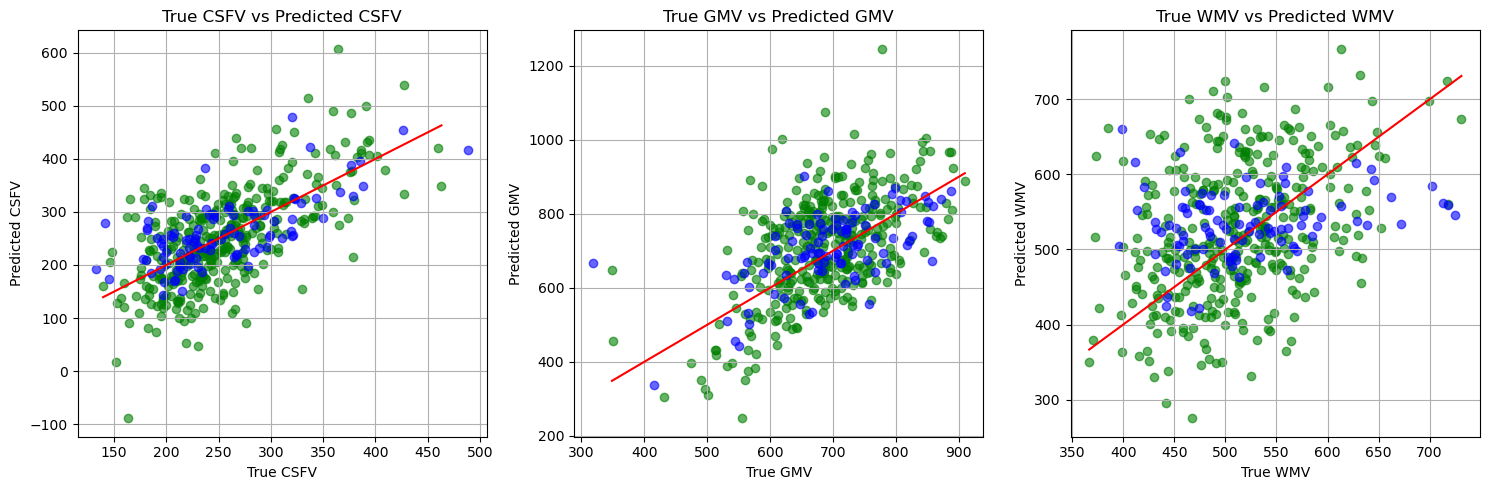

In [ ]:
plot_vol_predictions(model=base_linear_regression, train_data_loader=vol_train_loader, val_data_loader=vol_val_loader, norm_stats=volume_norm_stats)

Adding more iteration to try and improve the linear regression

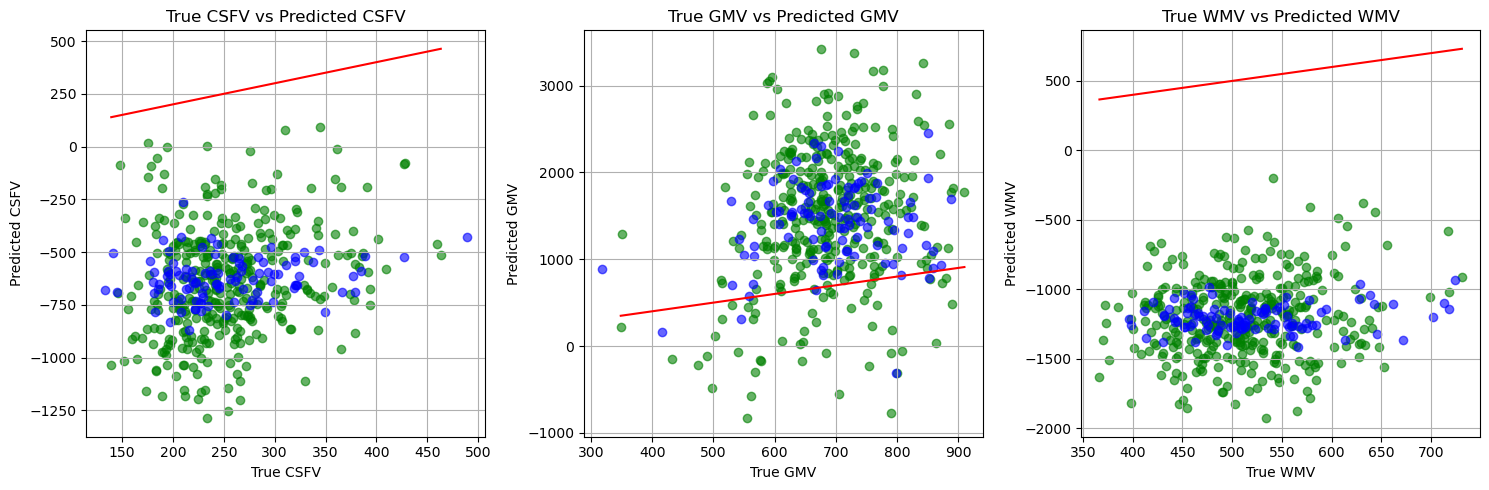

In [ ]:
plot_vol_predictions(model=base_linear_regression, train_data_loader=vol_train_loader, val_data_loader=vol_val_loader, norm_stats=volume_norm_stats)

In [ ]:
csfv_avg = train_meta_df["csfv"].mean()
gmv_avg = train_meta_df["gmv"].mean()
wmv_avg = train_meta_df["wmv"].mean()


In [ ]:
def get_loss_for_average_guess(dataloader, loss_fn, y_norm_stats):
    def denorm(y):
        return y.cpu() * y_norm_stats['std'] + y_norm_stats['mean']
    
    num_batches = len(dataloader)

    test_loss, mae_loss = 0, 0
    for data in dataloader:
        X, y = data['X'].to(device), data['y'].to(device)
        pred = torch.Tensor(y.size())
        
        test_loss += loss_fn(pred, y).item()
        mae_loss += torch.mean(torch.abs(denorm(pred) - denorm(y))).item()
    
    test_loss /= num_batches
    mae_loss /= num_batches
    print(f"Test loss: {test_loss:>8f}, MAE: {mae_loss:>8f}\n")
    return test_loss

get_loss_for_average_guess(vol_val_loader, vol_loss_fn, volume_norm_stats)

Test loss: 1.244120, MAE: 60.502063



1.244120446535257

In [198]:
get_loss_for_average_guess(e2e_val_loader, e2e_loss_fn, age_norm_stats)

Test loss: 1.474024, MAE: 10.409928



1.4740239091162735

## Part 3: Improving upon the Baseline

Here you should make three meaningful attempts to improve upon the baseline model.

Start by analysing the performance of the baseline model and propose a hypothesis for where the model could be improved. The hypothesis could align to one of:
* Architecture: Would a different NN architecture be better? Maybe try training a deep learning model end to end, rather than first predicting volumes then predicting age.
* Hyperparameters: Is the learning rate set correctly? Should early stopping or other kinds of regularizations be used?
* Auxiliary losses: Can you use the extra information in the training data to provide richer training signals to the model?
* Data augmentation: Can simple augmentations improve performance? (This can be especially helpful when the dataset is small!)
* Skewed dataset: Are there techniques that can be used to account for the negative effects of a skewed/imbalanced dataset?

Now implement a new model based on your hypothesis!

Iterate though this procedure until you have proposed 3 hypotheses and developed 3 models.

Don’t worry if an experiment does not produce the intended results - write about why you think it didn’t produce those results! Note, that since this is deep learning, there may not always be an obvious explanation - in these cases so long as your initial hypothesis was valid and you have made attempts to find an explanation (where possible) you will not lose marks.

If you feel a set of experiments are leading you down a dead end - don’t worry! Write about why you feel that line of enquiry is not working, take a few steps back (even if that means going back to the baseline model) and start again for your next hypothesis. Failed experiments often yield interesting and insightful results!

**Further guidelines for the hypotheses:**

* Scope: Ensure your hypothesis is not too limited in scope. For example, simply changing the learning rate value once would be insufficient. Instead, you could try a sweep over learning rates.
* Grounded reasoning: Your reasoning and justifications should be grounded in what you have learned in the course materials/lectures/tutorials. 
* Evidence-backed conclusions: If you are making conclusions, ensure to present suitably strong evidence. If there is not enough evidence to make a strong conclusion, ensure you acknowledge this.

**Marking:**

In the report, marks will primarily be awarded for:
- The quality of your hypotheses, and their justifications (including how you move from one hypothesis/experiment to the next)
- The quality/thoroughness of the experiments you run to test your hypotheses, and your presentation and discussion of the results

You will __not__ be marked on the overall performance of your model. This coursework is designed to test your ability to propose reasonable experiments and to test your understanding of the content of the course.

## 🚧 Exercise 3.1: Hypothesis 1 🚧

When detailing your Hypothesis 1-3 in the report, some points to touch on include:

- Explain your hypothesis and the reasoning behind it (e.g. why do you think this could improve performance, how does it relate to your previous experiment).
- How do you intend to test the hypothesis (i.e. what experiments will you run)?
- What evidence is required to confirm/disprove the hypothesis?
- What do you hope to learn from your experiments?

In [ ]:
########################################
# Test Hypothesis 1: INSERT CODE HERE
#
# Feel free to use as many cells as necessary
########################################

**3.1.1 - Motivation**

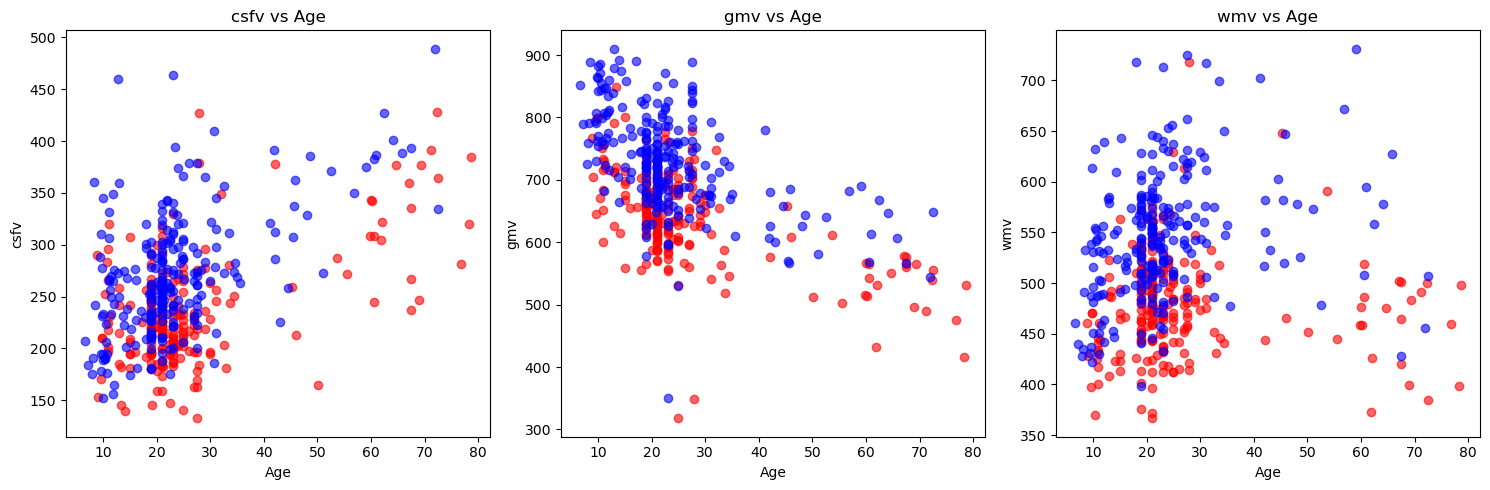

In [481]:
# Create scatter plots to visualize the correlation between volumes and age
def plot_cols_for_female_and_male(df, col_1, col_2, col_3):
    df_female = df[df["sex"] == "female"]
    df_male = df[df["sex"] == "male"]

    # Get ages
    ages_female = df_female["age"].values
    ages_male = df_male["age"].values

    # Get volumes
    volumes_female = df_female[[col_1, col_2, col_3]].values
    csfv_female = volumes_female[:,0]
    gmv_female = volumes_female[:,1]
    wmv_female = volumes_female[:,2]

    # Get volumes
    volumes_male = df_male[[col_1, col_2, col_3]].values
    csfv_male = volumes_male[:,0]
    gmv_male = volumes_male[:,1]
    wmv_male = volumes_male[:,2]

    # Create a figure and a 1x3 subplot (for 3 plots in a row)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot csfv vs age
    axes[0].scatter(ages_female, csfv_female, color='r', alpha=0.6)
    axes[0].scatter(ages_male, csfv_male, color='b', alpha=0.6)
    axes[0].set_title(f'{col_1} vs Age')
    axes[0].set_xlabel('Age')
    axes[0].set_ylabel(col_1)

    # Plot gmv vs age
    axes[1].scatter(ages_female, gmv_female, color='r', alpha=0.6)
    axes[1].scatter(ages_male, gmv_male, color='b', alpha=0.6)
    axes[1].set_title(f'{col_2} vs Age')
    axes[1].set_xlabel('Age')
    axes[1].set_ylabel(col_2)

    # Plot wmv vs age
    axes[2].scatter(ages_female, wmv_female, color='r', alpha=0.6)
    axes[2].scatter(ages_male, wmv_male, color='b', alpha=0.6)
    axes[2].set_title(f'{col_3} vs Age')
    axes[2].set_xlabel('Age')
    axes[2].set_ylabel(col_3)

    # Display the plots
    plt.tight_layout()
    plt.show()

plot_cols_for_female_and_male(train_meta_df, "csfv", "gmv", "wmv")

Analizing numerical column: ***csfv_proportion***
num nulls: 0 num zeros: 0
minimum: 0.09731984584831647 | maximum: 0.37167029268447116 | mean: 0.174101031946583 | std: 0.036363783474402986


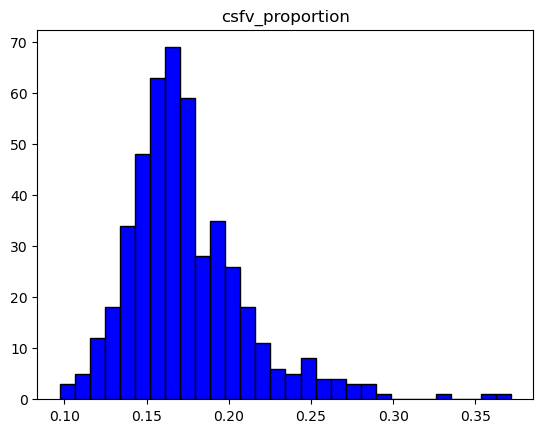

Analizing numerical column: ***gmv_proportion***
num nulls: 0 num zeros: 0
minimum: 0.28098861953334436 | maximum: 0.5648725877638666 | mean: 0.47311260933574856 | std: 0.03875779456825248


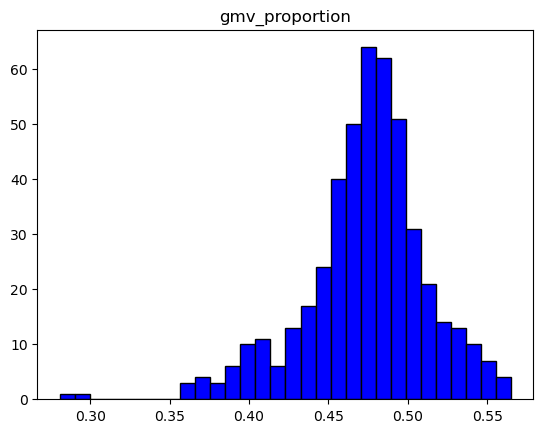

Analizing numerical column: ***wmv_proportion***
num nulls: 0 num zeros: 0
minimum: 0.28483097166887184 | maximum: 0.47288579819502 | mean: 0.3527863587176685 | std: 0.02291156011113442


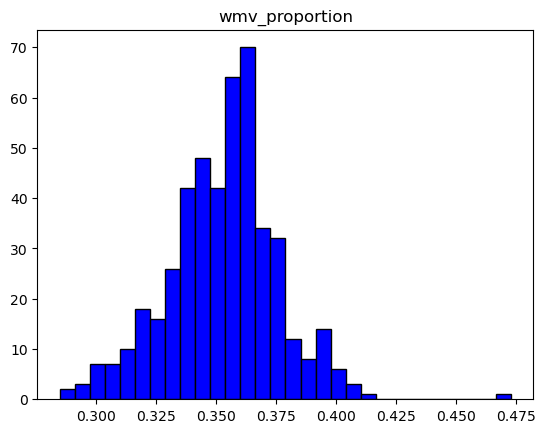

In [226]:
df_with_proportions = train_meta_df.copy()
general_volume = (df_with_proportions["csfv"] + df_with_proportions["gmv"] + df_with_proportions["wmv"])
df_with_proportions["csfv_proportion"] = df_with_proportions["csfv"] / general_volume
df_with_proportions["gmv_proportion"] = df_with_proportions["gmv"] / general_volume
df_with_proportions["wmv_proportion"] = df_with_proportions["wmv"] / general_volume
proportional_cols = ["csfv_proportion", "gmv_proportion", "wmv_proportion"]
for col in proportional_cols:
    analyse_numerical_column(col, df_with_proportions)

<Axes: >

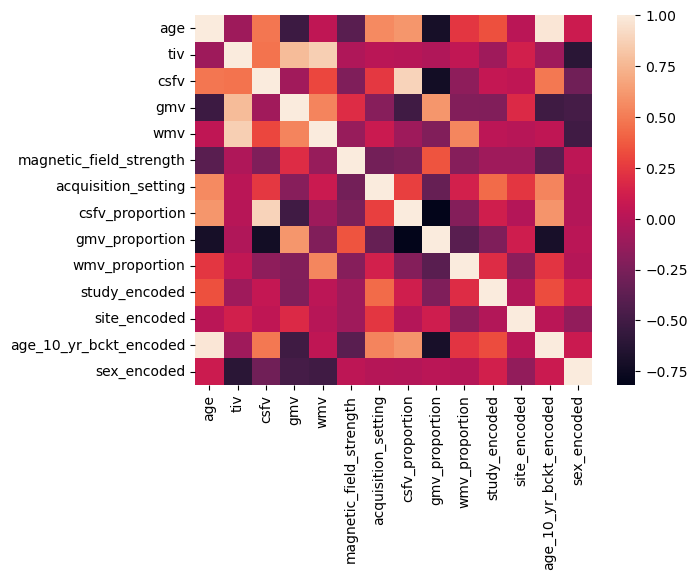

In [106]:
# To create a correlation map between the different feature, first encode all categorical features
import seaborn as sns

## Encoding categorical data to create a correlation hitmap
df_data_for_corr_matrix = df_with_proportions.copy()
df_data_for_corr_matrix["study_encoded"] = df_with_proportions.apply(lambda x: int(x["study"]), axis=1)
df_data_for_corr_matrix["site_encoded"] = df_with_proportions.apply(lambda x: float(x["site"]), axis=1)
df_data_for_corr_matrix["age_10_yr_bckt_encoded"] = df_with_proportions.apply(lambda x: x["age"] // 10, axis=1)
df_data_for_corr_matrix["sex_encoded"] = df_with_proportions.apply(lambda x: 1.0 if x["sex"] == "female" else 0.0, axis=1)

# For the correlation matrix to be concise, remove the data that is less 
df_data_for_corr_matrix.drop(columns=["age_10_yr_bckt_bg_70", "diagnosis", "age_10_yr_bckt", "study", "site", "sex", "age_round", "participant_id"], inplace=True)

sns.heatmap(df_data_for_corr_matrix.corr())

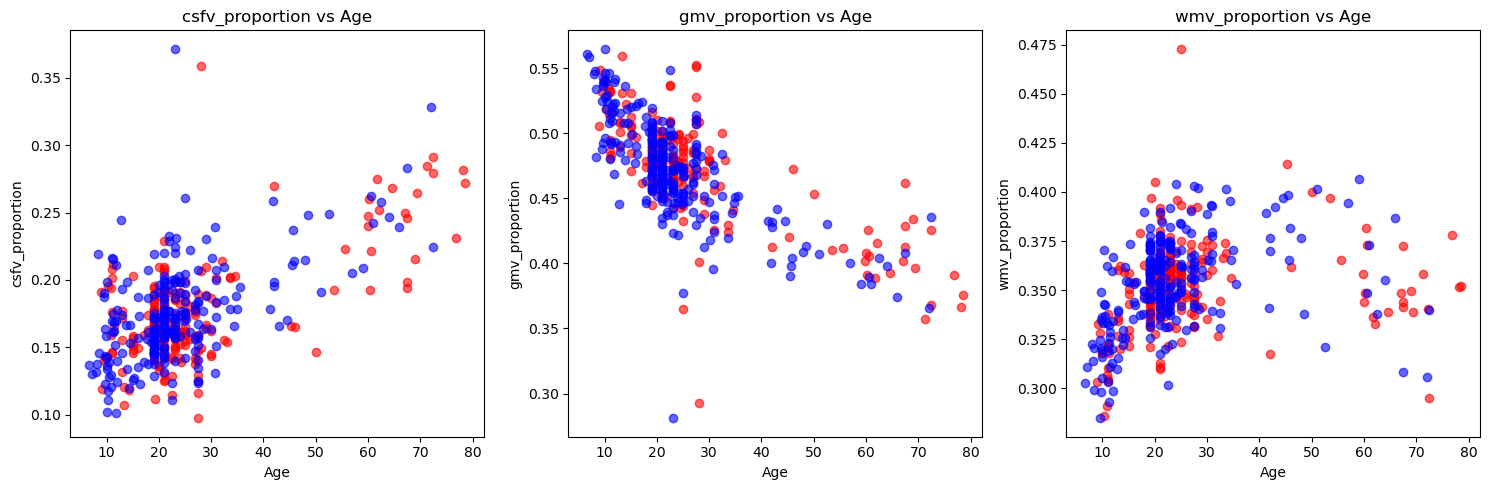

In [482]:
plot_cols_for_female_and_male(df_with_proportions, "csfv_proportion", "gmv_proportion", "wmv_proportion")

Comparing numerical column: ***csfv_proportion***
 Female mean: 0.174 | female std: 0.04 ## Male mean: 0.175 | male std: 0.04


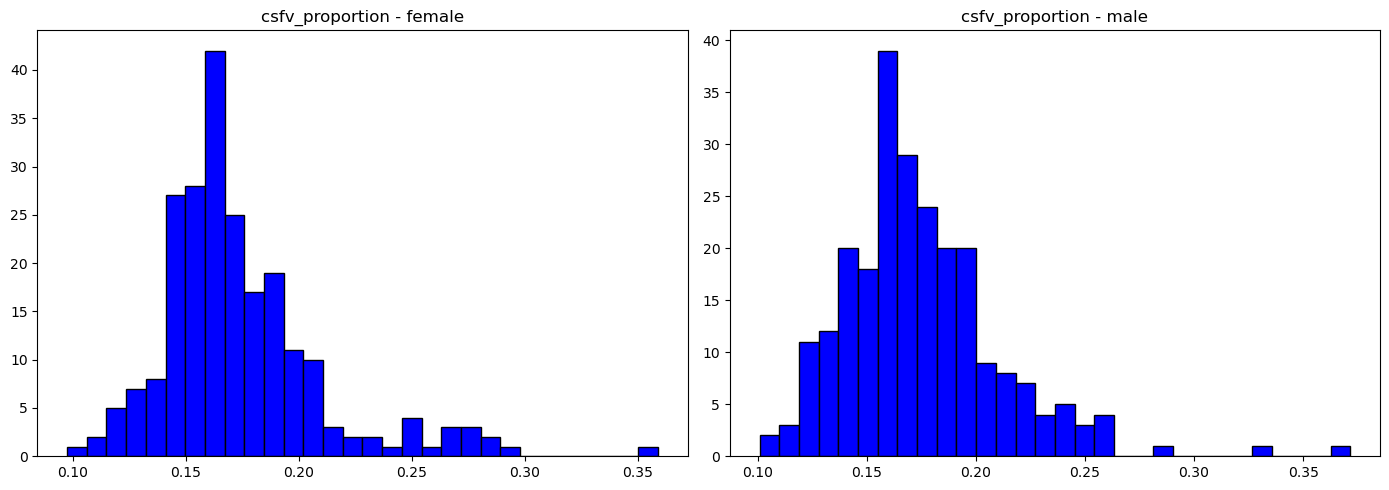

Comparing numerical column: ***gmv_proportion***
 Female mean: 0.474 | female std: 0.04 ## Male mean: 0.473 | male std: 0.04


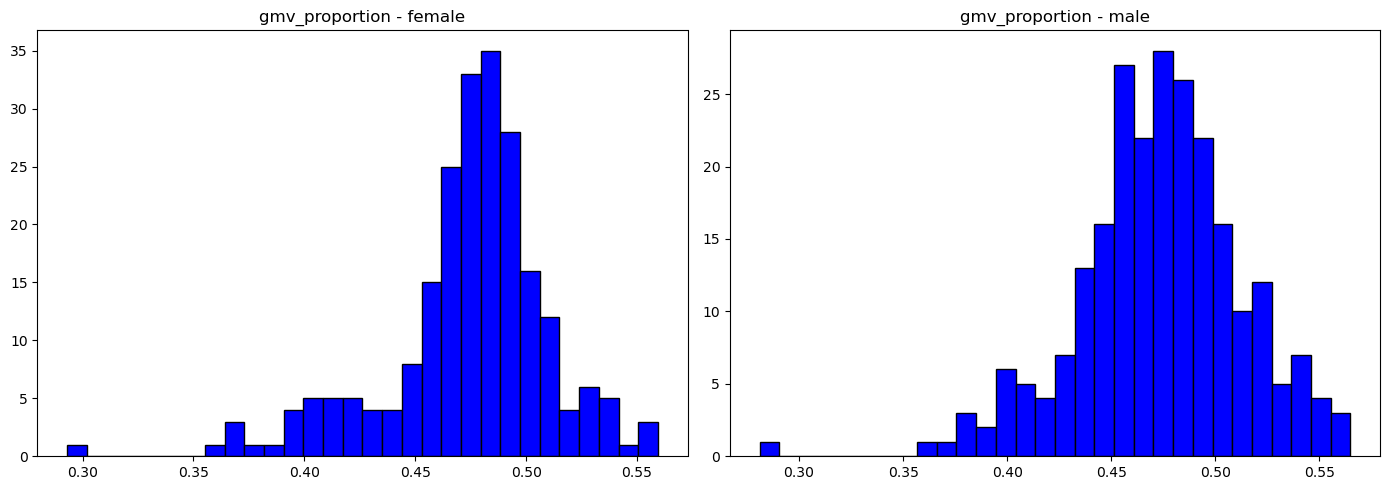

Comparing numerical column: ***wmv_proportion***
 Female mean: 0.353 | female std: 0.02 ## Male mean: 0.353 | male std: 0.02


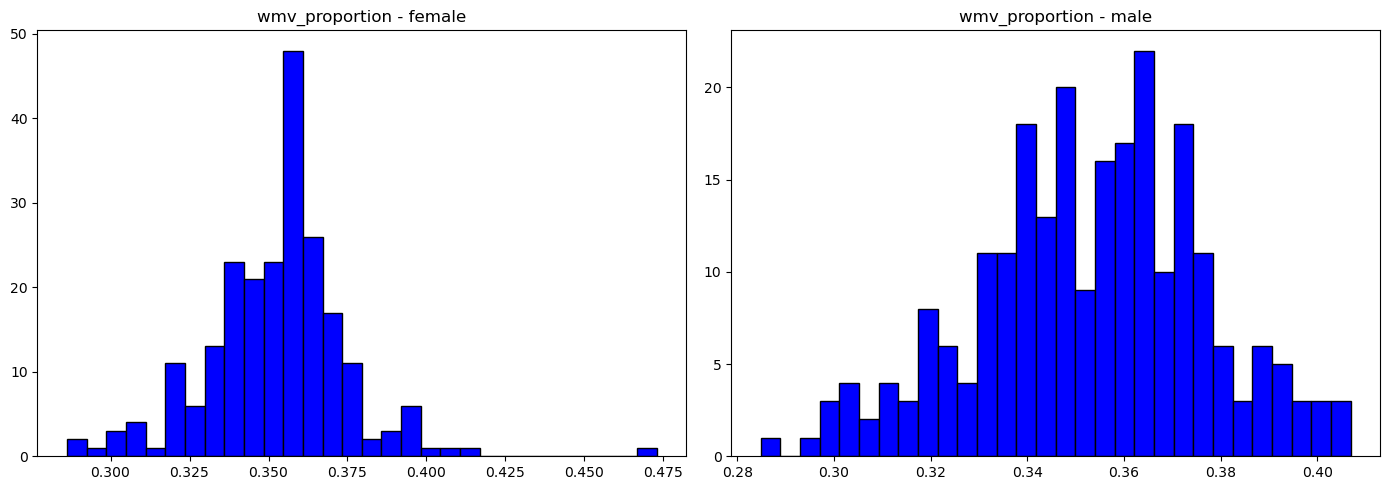

In [227]:
for col in proportional_cols:
    analyse_numerical_column_compare_sexes(col, df_with_proportions)

**3.1.2 Implementation**

In [228]:
proportioned_volume_norm_stats =  {
    'mean': df_with_proportions[["csfv_proportion", "gmv_proportion", "wmv_proportion"]].mean(axis=0).values,
    'std': df_with_proportions[["csfv_proportion", "gmv_proportion", "wmv_proportion"]].std(axis=0).values
}

In [229]:
rnd_seed = 42
batch_size = 2
torch.manual_seed(rnd_seed)

mlp_train_data_proportion_h1 = AgeRegressionDataset(
    patient_list=train_pats,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_volume_norm_stats,
    age_norm_stats=age_norm_stats,
    x_1_col="csfv_proportion",
    x_2_col="gmv_proportion",
    x_3_col="wmv_proportion",
)
mlp_train_loader_proportion_h1 = DataLoader(mlp_train_data_proportion_h1, batch_size=batch_size)

mlp_val_data_proportion_h1 = AgeRegressionDataset(
    patient_list=val_pats,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_volume_norm_stats,
    age_norm_stats=age_norm_stats,
    x_1_col="csfv_proportion",
    x_2_col="gmv_proportion",
    x_3_col="wmv_proportion",
)
mlp_val_loader_proportion_h1 = DataLoader(mlp_val_data_proportion_h1, batch_size=batch_size)

tmp = next(mlp_train_loader_proportion_h1.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (csfv, gmv, wmv brain volumes) dimensions are: {tmp['X'].shape}")
print(f"The output (patient age) dimensions are: {tmp['y'].shape}")

Loading Data:   0%|          | 0/365 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 101/101 [00:00<00:00, 687.90it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([2, 3])
The output (patient age) dimensions are: torch.Size([2])


In [230]:
tmp = next(mlp_train_loader_proportion_h1.__iter__())
in_shape = tmp['X'].shape[1:]
print(tmp['X'])
print(tmp['X'].shape)

mlp_model_proportion_h1 = MLPRegression(in_shape[0]).float().to(device)

output = mlp_model_proportion_h1(tmp['X'].to(device))
print("MLP Regression Model output shape: ", output.shape)

mlp_loss_fn = nn.MSELoss()
mlp_proportion_h1_optimizer = torch.optim.Adam(mlp_model_proportion_h1.parameters(), lr=1e-3)


tensor([[-0.9254,  1.5072, -1.0809],
        [ 0.4680,  0.8352, -2.1556]])
torch.Size([2, 3])
MLP Regression Model output shape:  torch.Size([2, 1])


Epoch 1
-------------------------------
Train loss: 0.687714
Test loss: 0.761936, MAE: 7.679437

Epoch 2
-------------------------------


/Users/user/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/user/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 0.594513
Test loss: 0.663413, MAE: 7.225583

Epoch 3
-------------------------------
Train loss: 0.576916
Test loss: 0.634028, MAE: 7.051466

Epoch 4
-------------------------------
Train loss: 0.567251
Test loss: 0.621550, MAE: 6.964470

Epoch 5
-------------------------------
Train loss: 0.560380
Test loss: 0.615855, MAE: 6.916245

Epoch 6
-------------------------------
Train loss: 0.554543
Test loss: 0.612634, MAE: 6.889434

Epoch 7
-------------------------------
Train loss: 0.549361
Test loss: 0.611436, MAE: 6.874845

Epoch 8
-------------------------------
Train loss: 0.545031
Test loss: 0.610237, MAE: 6.862296

Epoch 9
-------------------------------
Train loss: 0.540960
Test loss: 0.610339, MAE: 6.859885

Epoch 10
-------------------------------
Train loss: 0.537016
Test loss: 0.611833, MAE: 6.859985

Done!


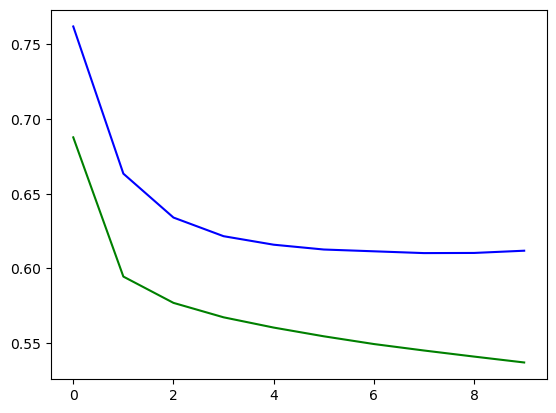

In [231]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(mlp_train_loader_proportion_h1, mlp_model_proportion_h1, mlp_loss_fn, mlp_proportion_h1_optimizer))
    test_losses.append(test(mlp_val_loader_proportion_h1, mlp_model_proportion_h1, mlp_loss_fn, age_norm_stats))
print("Done!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.show()

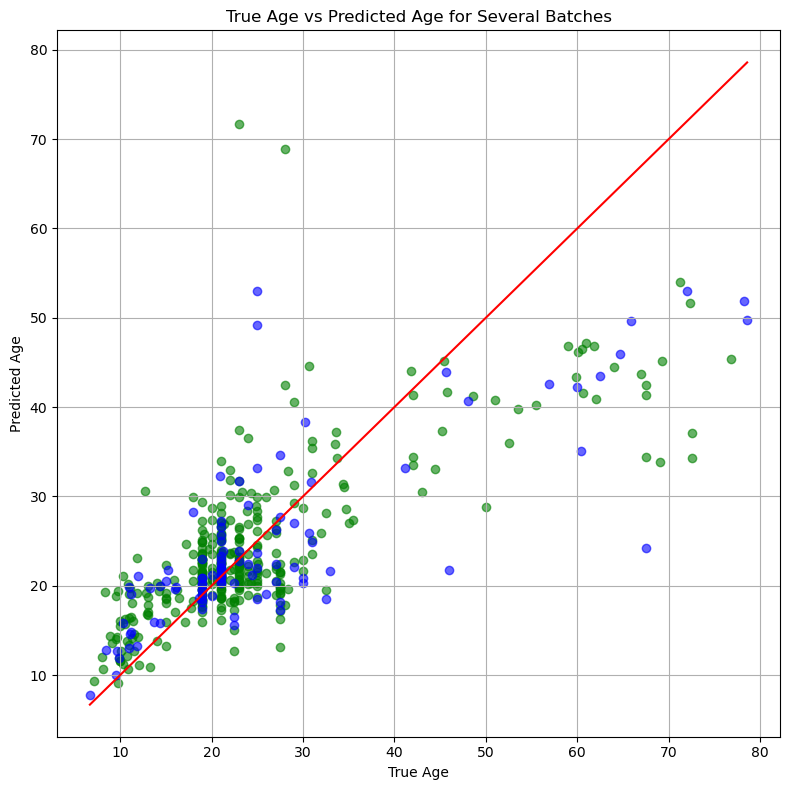

In [232]:
true_train, predicted_train = get_true_and_predicted_arrays(mlp_train_loader_proportion_h1, mlp_model_proportion_h1, age_norm_stats)
true_val, predicted_val = get_true_and_predicted_arrays(mlp_val_loader_proportion_h1, mlp_model_proportion_h1, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_train, predicted_train, alpha=0.6, color="green")
plt.scatter(true_val, predicted_val, alpha=0.6, color="blue")

plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Expect this cell to take 8 mins
rnd_seed=42
batch_size = 8 # Can be changed if you wish
torch.manual_seed(rnd_seed)

vol_train_data_proportion = VolumePredictionDataset(
    patient_list=train_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_volume_norm_stats,
    target_1_col="csfv_proportion",
    target_2_col="gmv_proportion",
    target_3_col="wmv_proportion",
)

vol_train_loader_proportion = DataLoader(vol_train_data_proportion, batch_size=batch_size)

vol_val_data_proportion = VolumePredictionDataset(
    patient_list=val_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_volume_norm_stats,
    target_1_col="csfv_proportion",
    target_2_col="gmv_proportion",
    target_3_col="wmv_proportion",
)

vol_val_loader_proportion = DataLoader(vol_val_data_proportion, batch_size=batch_size)

vol_test_data_proportion = VolumePredictionDataset(
    patient_list=test_pats, 
    mri_file_dir=TEST_MRI_DIR,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_volume_norm_stats,
    target_1_col="csfv_proportion",
    target_2_col="gmv_proportion",
    target_3_col="wmv_proportion",
)

tmp = next(vol_train_loader_proportion.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 167/167 [01:34<00:00,  1.77it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([8, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([8, 3])


torch.Size([8, 3])
Epoch 1
-------------------------------
Train loss: 0.934926
Test loss: 1.181852, MAE: 0.026227

Epoch 2
-------------------------------
Train loss: 0.786797
Test loss: 1.118319, MAE: 0.025854

Epoch 3
-------------------------------
Train loss: 0.681363
Test loss: 1.003518, MAE: 0.025263

Epoch 4
-------------------------------
Train loss: 0.562287
Test loss: 0.865581, MAE: 0.023574

Epoch 5
-------------------------------
Train loss: 0.465042
Test loss: 0.857320, MAE: 0.023272

Epoch 6
-------------------------------
Train loss: 0.364764
Test loss: 0.744852, MAE: 0.021306

Epoch 7
-------------------------------
Train loss: 0.253778
Test loss: 0.667591, MAE: 0.019734

Epoch 8
-------------------------------
Train loss: 0.186927
Test loss: 0.669409, MAE: 0.019595

Epoch 9
-------------------------------
Train loss: 0.147777
Test loss: 0.660145, MAE: 0.019395

Epoch 10
-------------------------------
Train loss: 0.119387
Test loss: 0.658847, MAE: 0.019416

Epoch 11
-

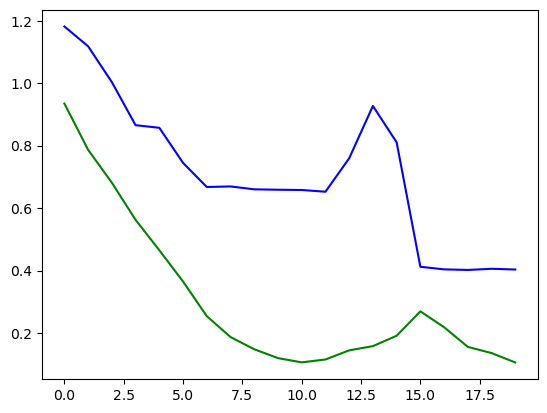

In [ ]:
# Define model and run a batch through the model to check it works
tmp = next(vol_train_loader_proportion.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]

vol_model_proportion = VolumePredictor(in_shape, out_size).float().to(device)

input = tmp['X'].to(device)
output = vol_model_proportion(input)
print(output.shape)

# Leaky Relu 0.0001 early stop
vol_loss_fn = nn.MSELoss()
vol_proportion_optimizer = torch.optim.Adam(vol_model_proportion.parameters(), lr=1e-4)

epochs = 20
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(vol_train_loader_proportion, vol_model_proportion, vol_loss_fn, vol_proportion_optimizer))
    test_losses.append(test(vol_val_loader_proportion, vol_model_proportion, vol_loss_fn, proportioned_volume_norm_stats))
print(f"Done training {epochs} epochs for vol_model_proportion!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.show()

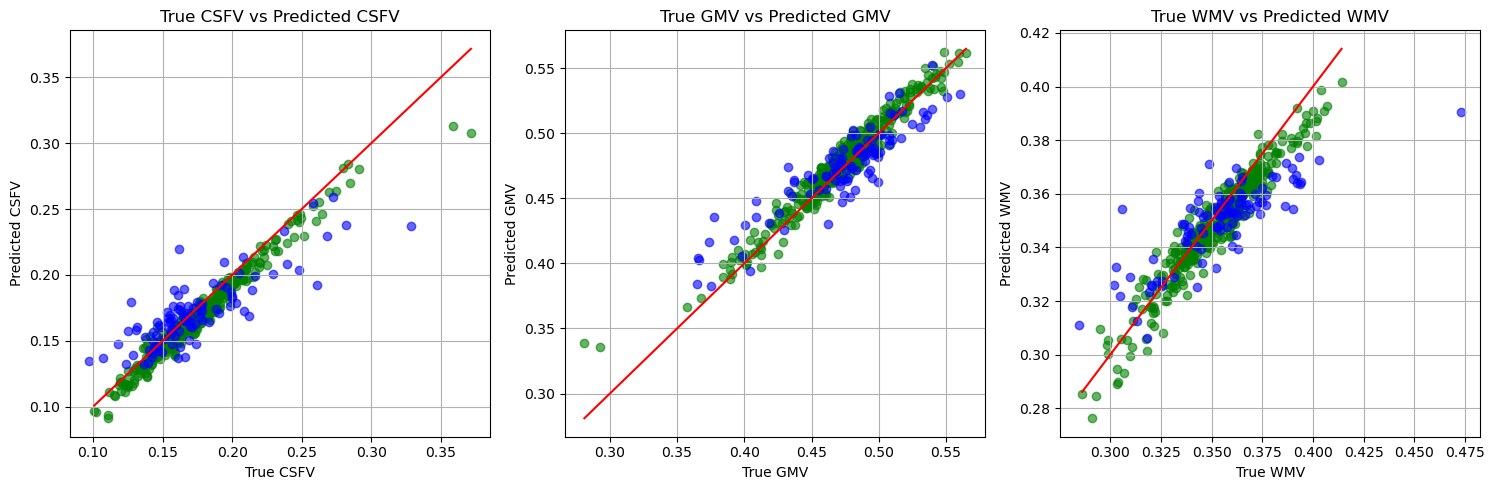

In [ ]:
plot_vol_predictions(vol_model_proportion, vol_train_loader_proportion, vol_val_loader_proportion, proportioned_volume_norm_stats)

In [ ]:
MODEL_DIR = "models"
with open(os.path.join(MODEL_DIR, "vol_model_proportion_not_cleaned.pkl"), "wb") as f:
    pickle.dump(vol_model_proportion, f)

In [669]:
combined_model_proportioned = CombinedModel(vol_model_proportion, mlp_model_proportion_h1).float().to(device)

tmp = next(e2e_val_loader.__iter__())
output = combined_model(tmp['X'].to(device))
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model_proportioned, e2e_loss_fn, age_norm_stats)


Test loss: 0.685904, MAE: 7.012982



0.685904239989445

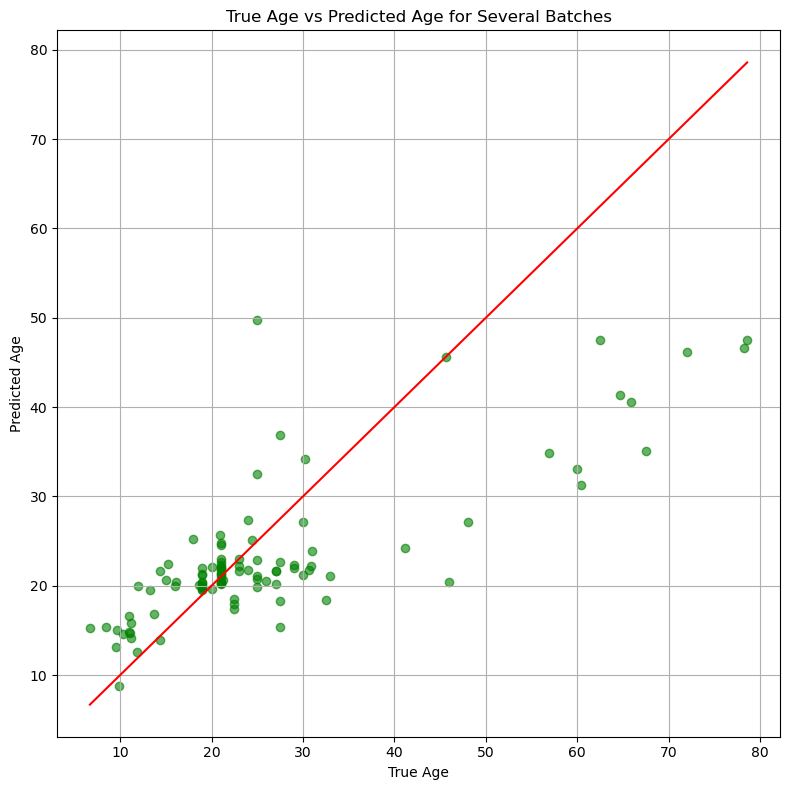

In [570]:
true_val, predicted_val = get_true_and_predicted_arrays(e2e_val_loader, combined_model_proportioned, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_val, predicted_val, alpha=0.6, color="green")

plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

## 🚧 Exercise 3.2: Hypothesis 2 🚧

**Clean outliers from proportioned dataframe used in Hypothesis 1**

**Motivation: Why should we clean outliers?**

Analizing numerical column: ***gmv_proportion***
num nulls: 0 num zeros: 0
minimum: 0.28098861953334436 | maximum: 0.5648725877638666 | mean: 0.47311260933574856 | std: 0.03875779456825248


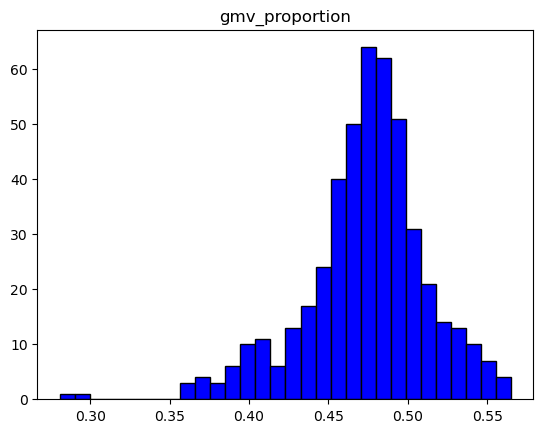

In [488]:
analyse_numerical_column("gmv_proportion", df_with_proportions)

In [236]:
gmv_proportion_outliers = df_with_proportions[df_with_proportions["gmv_proportion"] < 0.3]
print(f"num of outliers with low gmv proportion: {len(gmv_proportion_outliers)}")

outlier_ids = gmv_proportion_outliers["participant_id"].values
print(outlier_ids)

gmv_proportion_outliers[["participant_id", "age", "sex", "gmv_proportion", "wmv_proportion", "csfv_proportion"]].head()

num of outliers with low gmv proportion: 2
['145200850196' '167010474107']


participant_id   age     sex  gmv_proportion  wmv_proportion  \
161   145200850196  23.0    male        0.280989        0.347341   
227   167010474107  28.0  female        0.292982        0.348172   

     csfv_proportion  
161         0.371670  
227         0.358846

Analizing numerical column: ***wmv_proportion***
num nulls: 0 num zeros: 0
minimum: 0.28483097166887184 | maximum: 0.47288579819502 | mean: 0.3527863587176685 | std: 0.02291156011113442


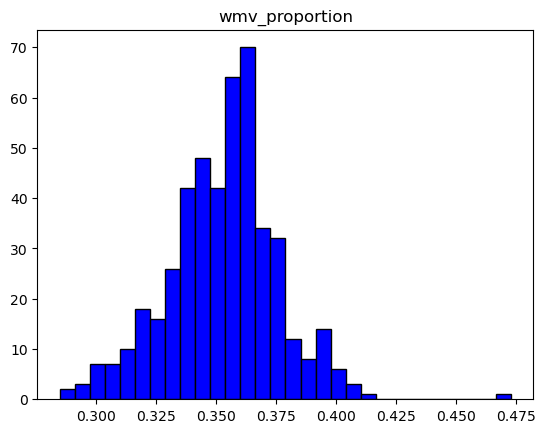

In [511]:
analyse_numerical_column("wmv_proportion", df_with_proportions)

In [238]:
wmv_proportion_outliers = df_with_proportions[df_with_proportions["wmv_proportion"] > 0.45]
print(f"num of outliers with high wmv proportion: {len(wmv_proportion_outliers)}")

wmv_outlier_ids = wmv_proportion_outliers["participant_id"].values
print(wmv_outlier_ids)
wmv_proportion_outliers.head()

for outlier_id in wmv_outlier_ids:
    if outlier_id in outlier_ids:
        print("found intersection between wmv outliers to previous outliers")
    else:
        outlier_ids = np.append(outlier_ids, outlier_id)

print(outlier_ids)

num of outliers with high wmv proportion: 1
['222716353013']
['145200850196' '167010474107' '222716353013']


In [239]:
wmv_proportion_outliers[["participant_id", "age", "sex", "gmv_proportion", "wmv_proportion", "csfv_proportion"]].head()

participant_id   age     sex  gmv_proportion  wmv_proportion  \
432   222716353013  25.0  female        0.365151        0.472886   

     csfv_proportion  
432         0.161963

Analizing numerical column: ***csfv_proportion***
num nulls: 0 num zeros: 0
minimum: 0.09731984584831647 | maximum: 0.37167029268447116 | mean: 0.174101031946583 | std: 0.036363783474402986


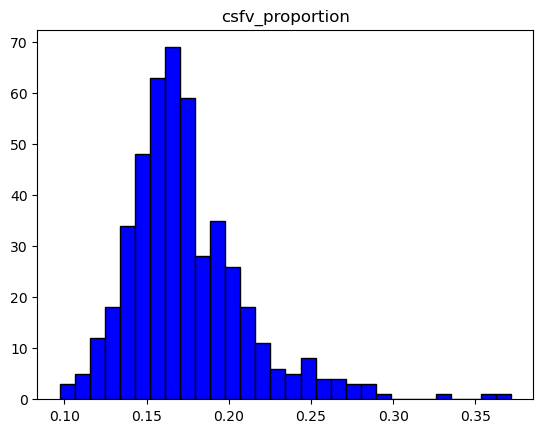

In [503]:
analyse_numerical_column("csfv_proportion", df_with_proportions)

**Clean Outliers**

In [241]:
csfv_proportion_outliers = df_with_proportions[df_with_proportions["csfv_proportion"] > 0.3]
csfv_proportion_outliers[["participant_id", "age", "sex", "gmv_proportion", "wmv_proportion", "csfv_proportion"]].head()

## old male with high csfv makes sense so it isn't an outlier, according to the graphs plotted before The 23 and 28 age old are
## Therefore remove only young patients with high csfv proportion

participant_id   age     sex  gmv_proportion  wmv_proportion  \
144   142102321393  72.0    male        0.365801        0.305933   
161   145200850196  23.0    male        0.280989        0.347341   
227   167010474107  28.0  female        0.292982        0.348172   

     csfv_proportion  
144         0.328265  
161         0.371670  
227         0.358846

In [520]:
csfv_proportion_outliers = df_with_proportions[(df_with_proportions["csfv_proportion"] > 0.3) & (df_with_proportions["age"] < 50)]
csfv_proportion_outliers.head()

participant_id study     sex   age site diagnosis          tiv  \
161   145200850196     6    male  23.0   52   control  1247.677816   
227   167010474107     6  female  28.0   52   control  1192.309478   

           csfv         gmv         wmv  magnetic_field_strength  \
161  463.252737  350.226396  432.928627                      3.0   
227  427.053216  348.670812  414.350694                      3.0   

     acquisition_setting  age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  \
161                  1.0         23             (20, 30]       (20, 30]   
227                  1.0         28             (20, 30]       (20, 30]   

     csfv_proportion  gmv_proportion  wmv_proportion  
161         0.371670        0.280989        0.347341  
227         0.358846        0.292982        0.348172

In [244]:
csfv_outlier_ids = csfv_proportion_outliers["participant_id"].values
print(csfv_outlier_ids)

for outlier_id in csfv_outlier_ids:
    if outlier_id in outlier_ids:
        print("found intersection between csfv outliers to previous outliers")
    else:
        outlier_ids = np.append(outlier_ids, outlier_id)

print(outlier_ids)

['142102321393' '145200850196' '167010474107']
found intersection between csfv outliers to previous outliers
found intersection between csfv outliers to previous outliers
['145200850196' '167010474107' '222716353013' '142102321393']


In [245]:
df_with_proportions_clean = df_with_proportions[~df_with_proportions["participant_id"].isin(outlier_ids)]
print(len(df_with_proportions_clean))
df_with_proportions_clean.head()

462


participant_id study     sex   age site diagnosis          tiv        csfv  \
0   100053248969     8  female  19.0   48   control  1434.357361  219.565569   
1   100263562592     4    male  21.0    3   control  1558.161428  261.968669   
2   100479214233     2  female  21.0   29   control  1418.050690  242.123816   
3   100544064116     3  female  15.0   65   control  1304.233543  206.305238   
4   101404752059     4    male  31.0    3   control  1660.856147  344.783456   

          gmv         wmv  magnetic_field_strength  acquisition_setting  \
0  678.230161  535.878459                      3.0                  1.0   
1  756.742506  538.817738                      3.0                  1.0   
2  686.814910  488.740580                      3.0                  1.0   
3  667.809720  429.723510                      3.0                  1.0   
4  703.484560  611.222413                      3.0                  1.0   

   age_round age_10_yr_bckt_bg_70 age_10_yr_bckt  csfv_proportion  \
0         19             (10, 20]       (10, 20]         0.153149   
1         21             (20, 30]       (20, 30]         0.168195   
2         21             (20, 30]       (20, 30]         0.170789   
3         15             (10, 20]       (10, 20]         0.158229   
4         31             (30, 40]       (30, 40]         0.207765   

   gmv_proportion  wmv_proportion  
0        0.473071        0.373780  
1        0.485861        0.345944  
2        0.484464        0.344747  
3        0.512187        0.329583  
4        0.423916        0.368319

**Implementation: Use clean data for model training** 
1. Use clean df to calculate norm
2. Make sure that only the training set is clean, but validation set will still contain the same examples as in the base model and h1. This is in order to ensure parity in the comparison of the performance validation sets for both models to impartially assess their performance, avoiding any potential advantage or bias toward one model over the other.

In [252]:
proportioned_clean_volume_norm_stats =  {
    'mean': df_with_proportions_clean[["csfv_proportion", "gmv_proportion", "wmv_proportion"]].mean(axis=0).values,
    'std': df_with_proportions_clean[["csfv_proportion", "gmv_proportion", "wmv_proportion"]].std(axis=0).values
}

In [249]:
train_pats_clean = train_pats[np.invert(np.in1d(train_pats, outlier_ids))]

print(f"Num training patients originally: {len(train_pats)}")
print(f"Num training patients after removing outliers: {len(train_pats_clean)}")
print(f"Num validation patients: {len(val_pats)}")


Num training patients originally: 365
Num training patients after removing outliers: 363
Num validation patients: 101


In [256]:
rnd_seed = 42
batch_size = 2
torch.manual_seed(rnd_seed)

mlp_train_data_h2 = AgeRegressionDataset(
    patient_list=train_pats_clean,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_clean_volume_norm_stats,
    age_norm_stats=age_norm_stats,
    x_1_col="csfv_proportion",
    x_2_col="gmv_proportion",
    x_3_col="wmv_proportion",
)
mlp_train_loader_h2 = DataLoader(mlp_train_data_h2, batch_size=batch_size)

mlp_val_data_h2 = AgeRegressionDataset(
    patient_list=val_pats,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_clean_volume_norm_stats,
    age_norm_stats=age_norm_stats,
    x_1_col="csfv_proportion",
    x_2_col="gmv_proportion",
    x_3_col="wmv_proportion",
)
mlp_val_loader_h2 = DataLoader(mlp_val_data_h2, batch_size=batch_size)


Loading Data: 100%|██████████| 101/101 [00:00<00:00, 677.62it/s]


In [257]:
tmp = next(mlp_train_loader_h2.__iter__())
in_shape = tmp['X'].shape[1:]
print(tmp['X'])
print(tmp['X'].shape)

mlp_model_h2 = MLPRegression(in_shape[0]).float().to(device)

output = mlp_model_h2(tmp['X'].to(device))
print("MLP Regression Model output shape: ", output.shape)

mlp_loss_fn = nn.MSELoss()
mlp_h2_optimizer = torch.optim.Adam(mlp_model_h2.parameters(), lr=1e-3)

tensor([[-0.9707,  1.5771, -1.1089],
        [ 0.5420,  0.8583, -2.2175]])
torch.Size([2, 3])
MLP Regression Model output shape:  torch.Size([2, 1])


Epoch 1
-------------------------------


/Users/user/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 0.475322
Test loss: 0.524141, MAE: 6.451584

Epoch 2
-------------------------------
Train loss: 0.337387
Test loss: 0.496986, MAE: 6.095269

Epoch 3
-------------------------------
Train loss: 0.308010
Test loss: 0.496764, MAE: 6.000518

Epoch 4
-------------------------------
Train loss: 0.297085
Test loss: 0.498290, MAE: 5.966003

Epoch 5
-------------------------------
Train loss: 0.290818
Test loss: 0.498450, MAE: 5.953861

Epoch 6
-------------------------------
Train loss: 0.286403
Test loss: 0.497963, MAE: 5.932702

Epoch 7
-------------------------------
Train loss: 0.283184
Test loss: 0.497667, MAE: 5.907161

Epoch 8
-------------------------------
Train loss: 0.280792
Test loss: 0.497752, MAE: 5.876791

Epoch 9
-------------------------------
Train loss: 0.278996
Test loss: 0.497935, MAE: 5.853831

Epoch 10
-------------------------------
Train loss: 0.277760
Test loss: 0.498469, MAE: 5.839305

Done!


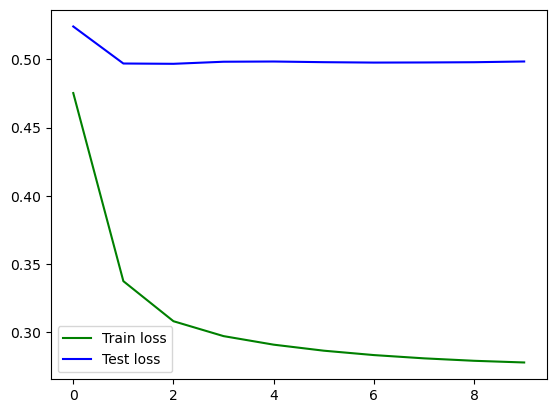

In [258]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(mlp_train_data_h2, mlp_model_h2, mlp_loss_fn, mlp_h2_optimizer))
    test_losses.append(test(mlp_val_data_h2, mlp_model_h2, mlp_loss_fn, age_norm_stats))
print("Done!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.legend()
plt.show()

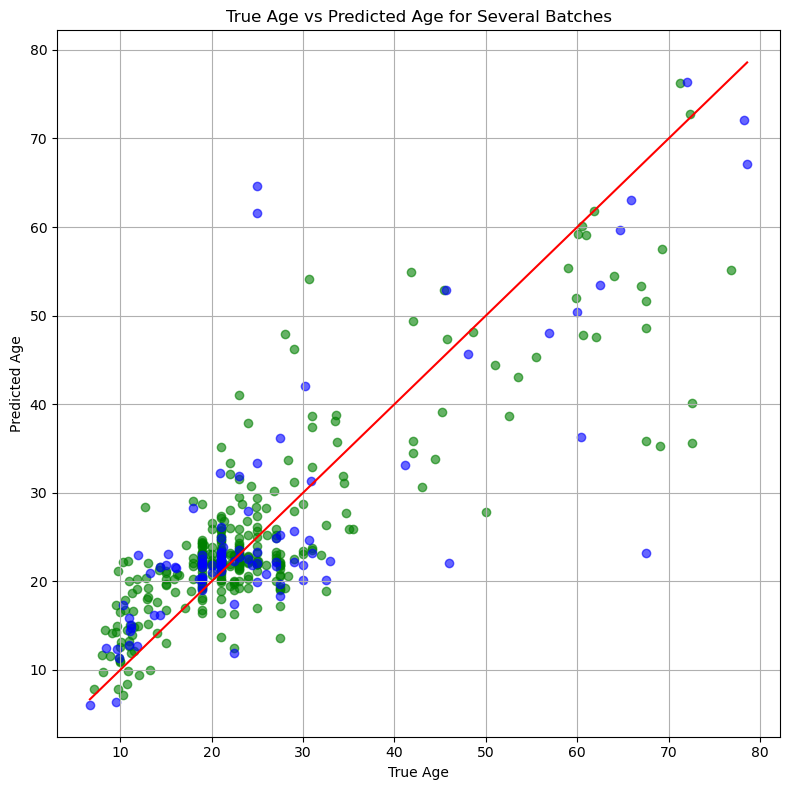

In [259]:
true_train, predicted_train = get_true_and_predicted_arrays(mlp_train_data_h2, mlp_model_h2, age_norm_stats)
true_val, predicted_val = get_true_and_predicted_arrays(mlp_val_data_h2, mlp_model_h2, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_train, predicted_train, alpha=0.6, color="green")
plt.scatter(true_val, predicted_val, alpha=0.6, color="blue")

plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

In [265]:
# Expect this cell to take 8 mins
rnd_seed=42
batch_size = 8 # Can be changed if you wish
torch.manual_seed(rnd_seed)

vol_train_data_h2 = VolumePredictionDataset(
    patient_list=train_pats_clean, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_clean_volume_norm_stats,
    target_1_col="csfv_proportion",
    target_2_col="gmv_proportion",
    target_3_col="wmv_proportion",
)

vol_train_loader_h2 = DataLoader(vol_train_data_h2, batch_size=batch_size)

vol_val_data_h2 = VolumePredictionDataset(
    patient_list=val_pats, 
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_clean_volume_norm_stats,
    target_1_col="csfv_proportion",
    target_2_col="gmv_proportion",
    target_3_col="wmv_proportion",
)

vol_val_loader_h2 = DataLoader(vol_val_data_h2, batch_size=batch_size)

vol_test_data_h2 = VolumePredictionDataset(
    patient_list=test_pats, 
    mri_file_dir=TEST_MRI_DIR,
    meta_df=df_with_proportions,
    volume_norm_stats=proportioned_clean_volume_norm_stats,
    target_1_col="csfv_proportion",
    target_2_col="gmv_proportion",
    target_3_col="wmv_proportion",
)

tmp = next(vol_train_loader_h2.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")


Loading Data: 100%|██████████| 167/167 [01:32<00:00,  1.81it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([8, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([8, 3])


torch.Size([8, 3])
Epoch 1
-------------------------------
Train loss: 0.961463
Test loss: 1.324418, MAE: 0.026213

Epoch 2
-------------------------------
Train loss: 0.841352
Test loss: 1.201334, MAE: 0.024668

Epoch 3
-------------------------------
Train loss: 0.690678
Test loss: 1.070421, MAE: 0.023632

Epoch 4
-------------------------------
Train loss: 0.537182
Test loss: 0.851656, MAE: 0.021813

Epoch 5
-------------------------------
Train loss: 0.380410
Test loss: 0.679453, MAE: 0.019781

Epoch 6
-------------------------------
Train loss: 0.218164
Test loss: 0.564289, MAE: 0.017569

Epoch 7
-------------------------------
Train loss: 0.137199
Test loss: 0.490267, MAE: 0.016222

Epoch 8
-------------------------------
Train loss: 0.110786
Test loss: 0.516107, MAE: 0.017248

Epoch 9
-------------------------------
Train loss: 0.077648
Test loss: 0.454967, MAE: 0.015925

Epoch 10
-------------------------------
Train loss: 0.093437
Test loss: 0.555435, MAE: 0.018635

Epoch 11
-

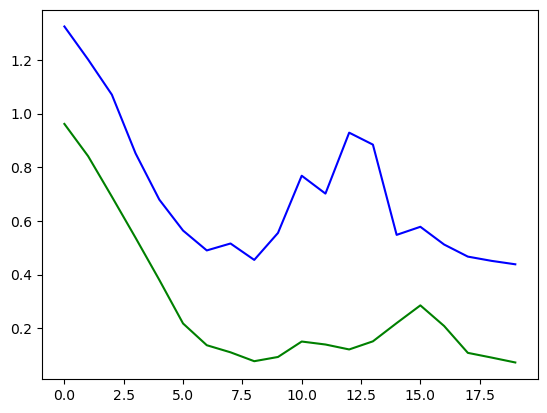

In [552]:
# Define model and run a batch through the model to check it works
tmp = next(vol_train_loader_h2.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]

vol_model_h2 = VolumePredictor(in_shape, out_size).float().to(device)

input = tmp['X'].to(device)
output = vol_model_h2(input)
print(output.shape)

vol_loss_fn = nn.MSELoss()
vol_h2_optimizer = torch.optim.Adam(vol_model_h2.parameters(), lr=1e-4)

epochs = 20
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(vol_train_loader_h2, vol_model_h2, vol_loss_fn, vol_h2_optimizer))
    test_losses.append(test(vol_val_loader_h2, vol_model_h2, vol_loss_fn, proportioned_clean_volume_norm_stats))
print(f"Done training {epochs} epochs for vol_model_proportion!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.show()

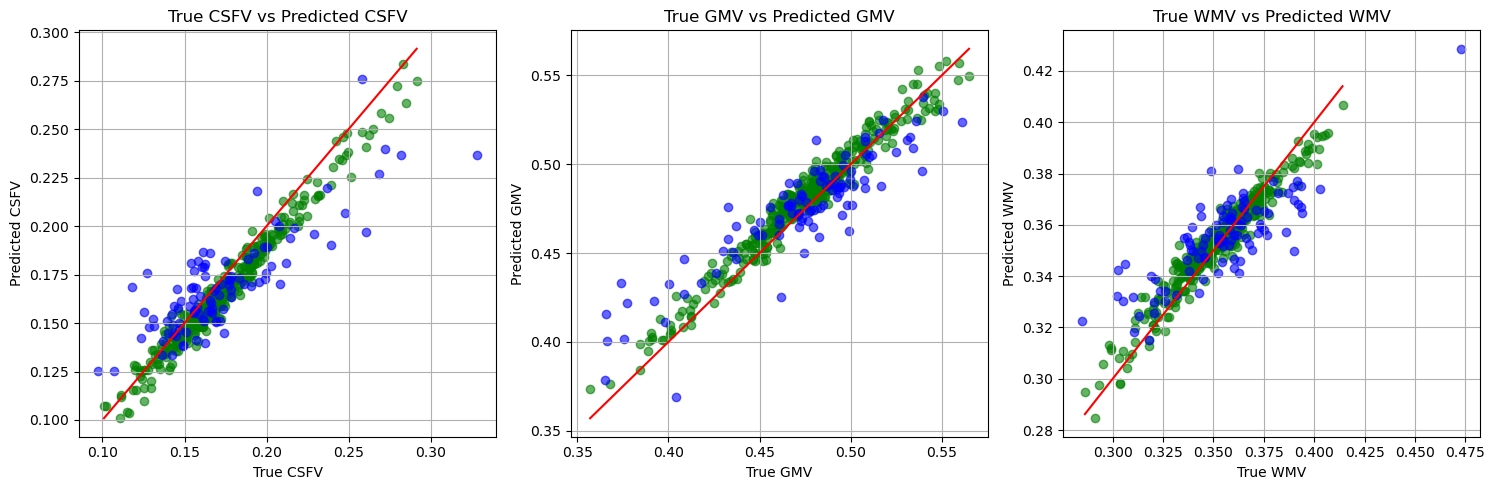

In [553]:
plot_vol_predictions(vol_model_h2, vol_train_loader_h2, vol_val_loader_h2, proportioned_clean_volume_norm_stats)

In [554]:
MODEL_DIR = "models"
with open(os.path.join(MODEL_DIR, "vol_model_h2.pkl"), "wb") as f:
    pickle.dump(vol_model_h2, f)

In [577]:
combined_model_h2 = CombinedModel(vol_model_h2, mlp_model_h2).float().to(device)

tmp = next(e2e_val_loader.__iter__())
output = combined_model_h2(tmp['X'].to(device))
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model_h2, e2e_loss_fn, age_norm_stats)

# proportion model, with no cleaning outliers

Test loss: 0.682367, MAE: 7.082492



0.6823666623551581

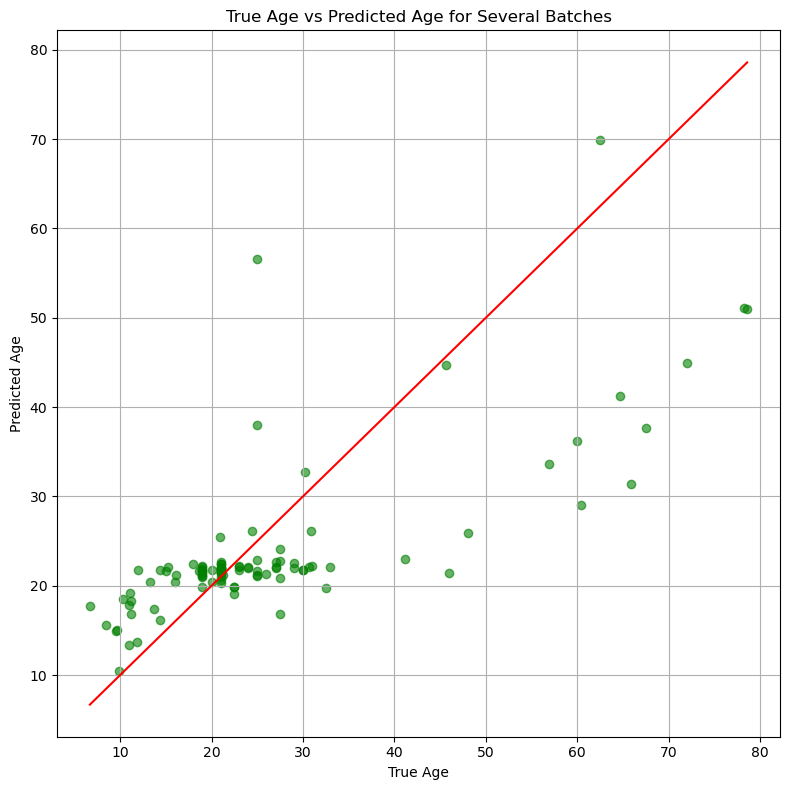

In [578]:
true_val, predicted_val = get_true_and_predicted_arrays(e2e_val_loader, combined_model_h2, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_val, predicted_val, alpha=0.6, color="green")

plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

## 🚧 Exercise 3.3: Hypothesis 3 🚧

**Age MLP**

In [379]:
class MLPRegressionH3(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPRegressionH3, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.leakyrelu = nn.LeakyReLU(0.0001)
        
    def forward(self, x):
        x = self.leakyrelu(self.linear1(x))
        x = self.linear2(x)
        return x


In [380]:
torch.manual_seed(rnd_seed)
tmp = next(mlp_train_loader_proportion_h1.__iter__())
in_shape = tmp['X'].shape[1:]

mlp_model_h3 = MLPRegressionH3(in_shape[0]).float().to(device)

output = mlp_model_h3(tmp['X'].to(device))
print("MLP Regression Model output shape: ", output.shape)
mlp_loss_fn = nn.MSELoss()
mlp_optimizer_h3 = torch.optim.Adam(mlp_model_h3.parameters(), lr=3* 1e-4)

MLP Regression Model output shape:  torch.Size([2, 1])


Epoch 1
-------------------------------
Train loss: 0.832624
Test loss: 1.147685, MAE: 8.795818

Epoch 2
-------------------------------


/Users/user/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/user/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 0.625266
Test loss: 0.883832, MAE: 8.010210

Epoch 3
-------------------------------
Train loss: 0.516555
Test loss: 0.731300, MAE: 7.543909

Epoch 4
-------------------------------
Train loss: 0.454841
Test loss: 0.640381, MAE: 7.199938

Epoch 5
-------------------------------
Train loss: 0.416642
Test loss: 0.584563, MAE: 6.929413

Epoch 6
-------------------------------
Train loss: 0.391083
Test loss: 0.549675, MAE: 6.722932

Epoch 7
-------------------------------
Train loss: 0.372878
Test loss: 0.527537, MAE: 6.559469

Epoch 8
-------------------------------
Train loss: 0.359860
Test loss: 0.514078, MAE: 6.431316

Epoch 9
-------------------------------
Train loss: 0.350401
Test loss: 0.506152, MAE: 6.321800

Epoch 10
-------------------------------
Train loss: 0.343457
Test loss: 0.501616, MAE: 6.228468

Epoch 11
-------------------------------
Train loss: 0.338176
Test loss: 0.499099, MAE: 6.148914

Epoch 12
-------------------------------
Train loss: 0.333952
Test l

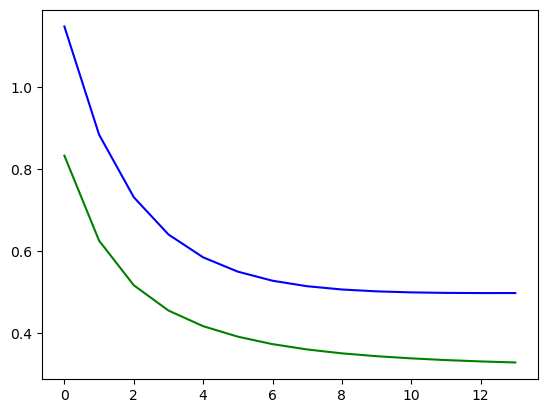

In [381]:
epochs = 14
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(mlp_train_loader_h2, mlp_model_h3, mlp_loss_fn, mlp_optimizer_h3))
    test_losses.append(test(mlp_val_loader_h2, mlp_model_h3, mlp_loss_fn, age_norm_stats))
print("Done!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.show()

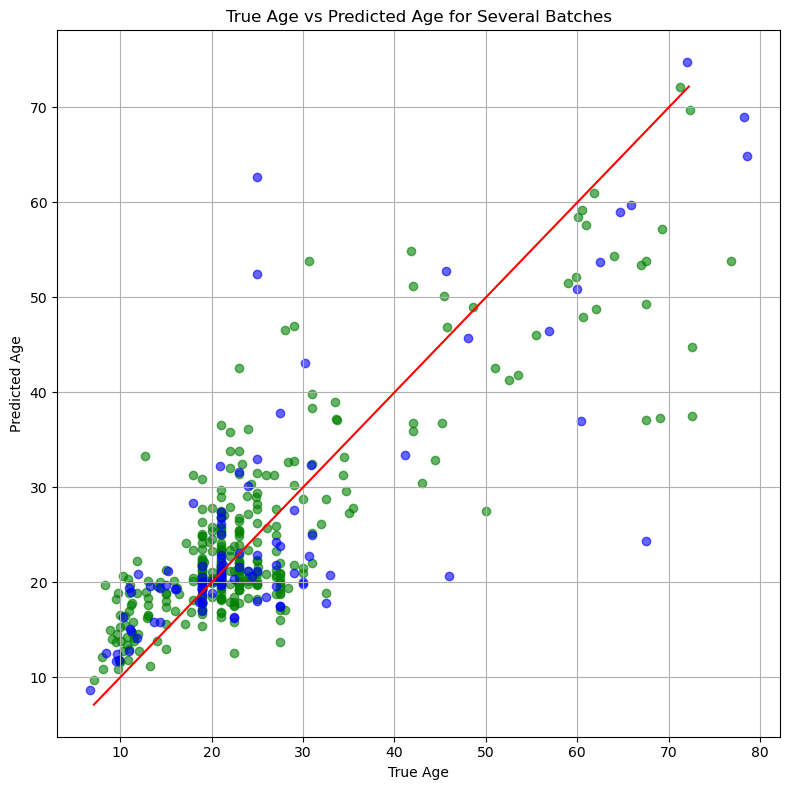

In [366]:
true_train, predicted_train = get_true_and_predicted_arrays(mlp_train_loader_h2, mlp_model_h3, age_norm_stats)
true_val, predicted_val = get_true_and_predicted_arrays(mlp_val_loader_h2, mlp_model_h3, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_train, predicted_train, alpha=0.6, color="green")
plt.scatter(true_val, predicted_val, alpha=0.6, color="blue")

plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_train), max(predicted_train)], [min(true_train), max(predicted_train)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

**Volume CNN**

In [386]:
class VolumePredictorH3(nn.Module):
    def __init__(self, in_shape, out_size):
        super(VolumePredictorH3, self).__init__()
        ##################
        # Your code here #
        ##################
        self.conv_relu_pool_stack = nn.Sequential(
            # Layer 1
            nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3),
            nn.LeakyReLU(0.0001),
            nn.AvgPool3d(2),

            # # Layer 2
            nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3),
            nn.LeakyReLU(0.0001),
            nn.AvgPool3d(2),
        )

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(22 * 22 * 22, 32)
        self.leakyrelu = nn.LeakyReLU(0.0001)
        self.linear2 = nn.Linear(32, 3)


    def forward(self, x):
        ##################
        # Your code here #
        ##################
        # print(f"got x with shape {x.shape}")
        x = self.conv_relu_pool_stack(x)
        x = self.flatten(x)
        x = self.leakyrelu(self.linear1(x))
        x = self.linear2(x)
        # print(f"after out layer, shape of x is: {x.shape}")
        return x

In [387]:
# Define model and run a batch through the model to check it works
torch.manual_seed(rnd_seed)
tmp = next(vol_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]

volume_model_h3_early_stopping = VolumePredictorH3(in_shape, out_size).float().to(device)

input = tmp['X'].to(device)
output = volume_model_h3_early_stopping(input)
print(output.shape)

vol_loss_fn = nn.MSELoss()
volume_h3_early_stopping_optimizer = torch.optim.Adam(volume_model_h3_early_stopping.parameters(), lr=1e-3) #possible 5*1e-4 with 20 epochs

torch.Size([8, 3])


Epoch 1
-------------------------------
Train loss: 1.024676
Test loss: 1.440084, MAE: 0.026958

Epoch 2
-------------------------------
Train loss: 0.982744
Test loss: 1.432779, MAE: 0.026858

Epoch 3
-------------------------------
Train loss: 0.973128
Test loss: 1.412671, MAE: 0.026510

Epoch 4
-------------------------------
Train loss: 0.938462
Test loss: 1.385632, MAE: 0.026339

Epoch 5
-------------------------------
Train loss: 0.897448
Test loss: 1.299457, MAE: 0.025527

Epoch 6
-------------------------------
Train loss: 0.860211
Test loss: 1.330398, MAE: 0.026076

Epoch 7
-------------------------------
Train loss: 0.749196
Test loss: 1.218945, MAE: 0.028007

Epoch 8
-------------------------------
Train loss: 0.800457
Test loss: 1.175269, MAE: 0.025055

Epoch 9
-------------------------------
Train loss: 0.575797
Test loss: 0.789876, MAE: 0.021334

Epoch 10
-------------------------------
Train loss: 0.430820
Test loss: 0.602820, MAE: 0.018152

Epoch 11
--------------------

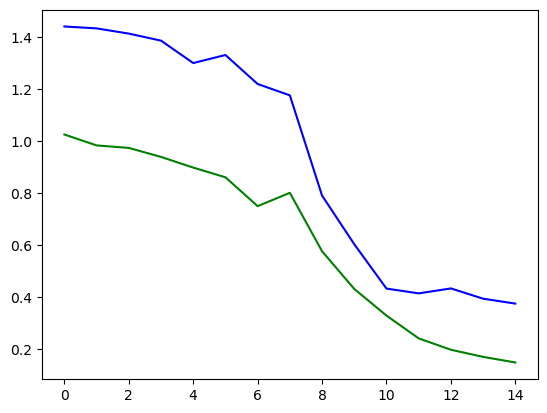

In [388]:
epochs = 15
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(vol_train_loader_h2, volume_model_h3_early_stopping, vol_loss_fn, volume_h3_early_stopping_optimizer))
    test_losses.append(test(vol_val_loader_h2, volume_model_h3_early_stopping, vol_loss_fn, proportioned_clean_volume_norm_stats))
print(f"Done training {epochs} epochs for vol_model_h3!")
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.show()

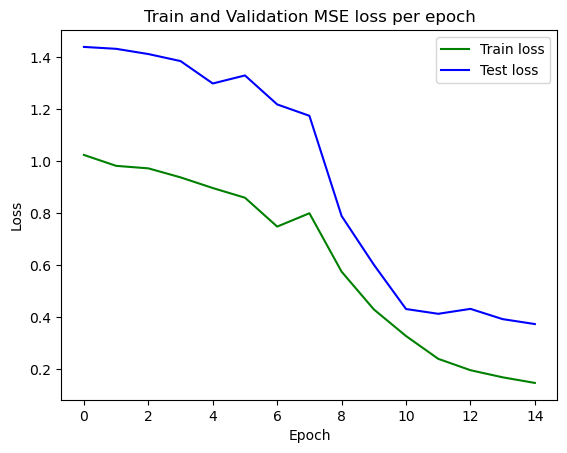

In [391]:
plt.plot(range(epochs), train_losses, 'g', label='Train loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.title('Train and Validation MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [390]:
MODEL_DIR = "models"
with open(os.path.join(MODEL_DIR, "vol_model_h3_2_layers_mlp_head.pkl"), "wb") as f:
    pickle.dump(volume_model_h3_early_stopping, f)

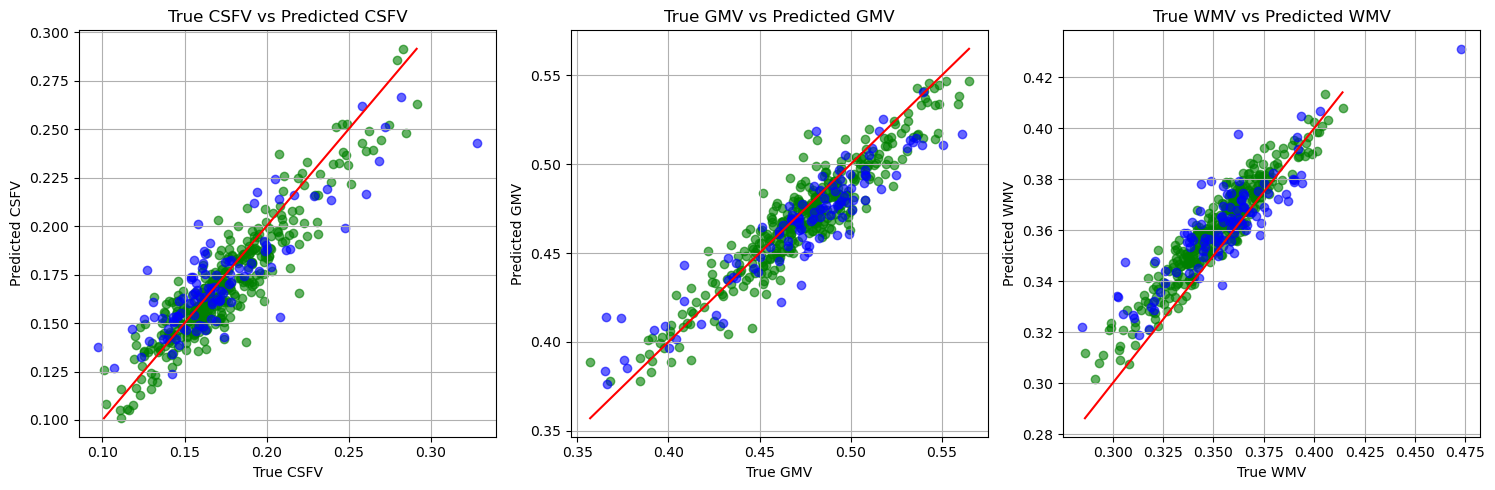

In [389]:
plot_vol_predictions(volume_model_h3_early_stopping, vol_train_loader_h2, vol_val_loader_h2, proportioned_clean_volume_norm_stats)

**Combined Model**

In [395]:
combined_model_h3 = CombinedModel(volume_model_h3_early_stopping, mlp_model_h3).float().to(device)

tmp = next(e2e_val_loader.__iter__())
output = combined_model_h3(tmp['X'].to(device))

e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model_h3, e2e_loss_fn, age_norm_stats)

Test loss: 0.508207, MAE: 6.753403



0.5082071426697761

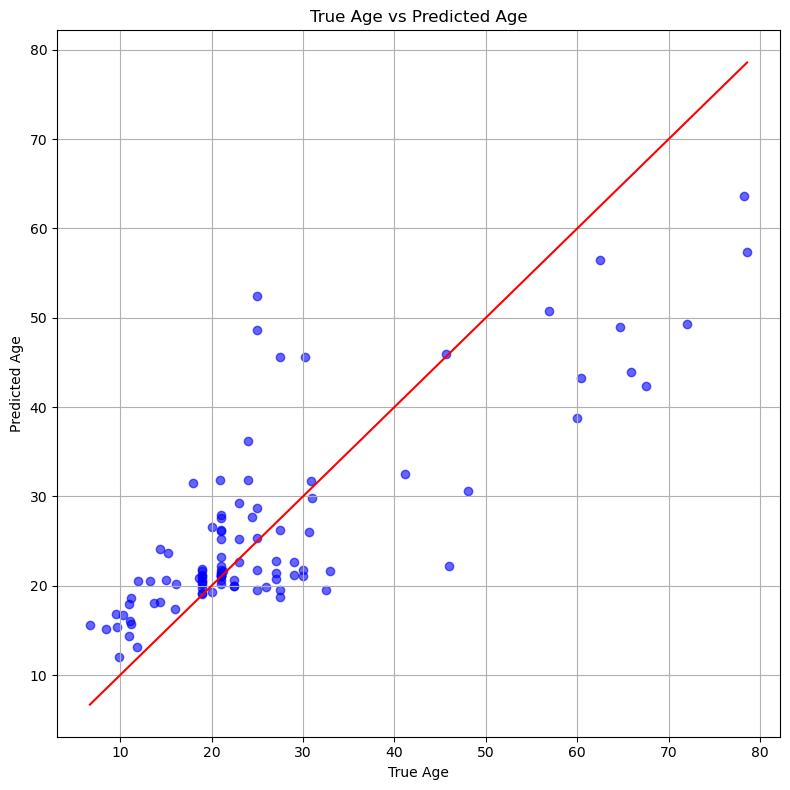

In [393]:
true_val, predicted_val = get_true_and_predicted_arrays(e2e_val_loader, combined_model_h3, age_norm_stats)

plt.figure(figsize=(8, 8))
plt.scatter(true_val, predicted_val, alpha=0.6, color="blue")

plt.title('True Age vs Predicted Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

## 🚧 Exercise 3.4: Concluding Discussion 🚧

Now you should have trained and validated 4 models (the baseline, and your 3 hypotheses). Below, you should do a final comparison of performances of the models **using the test data!**. This should be the **first and only time** you use the test data!

In your report, you should discuss potential reasons for differences in performance between all 4 models, and conclude which model is best (if any)

**Baseline Model**

In [402]:
################################################
# INSERT CODE HERE
################################################

def plot_test_restuls(e2e_data_loader, combined_model, age_norm_stats, model_name):
    true_ages, predicted_ages = get_true_and_predicted_arrays(e2e_data_loader, combined_model, age_norm_stats)

    plt.figure(figsize=(8, 8))
    plt.scatter(true_ages, predicted_ages, alpha=0.6, color="purple", label="Test Data")

    plt.title(f'True Age vs Predicted Age on Test Set: {model_name}')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.plot([min(true_ages), max(true_ages)], [min(true_ages), max(true_ages)], color='red')  # Line of best fit
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [397]:
# Evaluating base model on test data
e2e_test_data_base = EndToEndDataset(
    patient_list=test_pats, 
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df,
    ages_norm_stats=age_norm_stats,
)

e2e_test_loader = DataLoader(e2e_test_data_base, batch_size=2)



Loading Data: 100%|██████████| 167/167 [01:35<00:00,  1.74it/s]


Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input dimensions are: torch.Size([2, 1, 96, 96, 96])
The output dimensions are: torch.Size([2, 1])


In [400]:
combined_model_baseline = CombinedModel(vol_model_leaky_base_early_stop, mlp_model_base).float().to(device)

tmp = next(e2e_test_loader.__iter__())
output = combined_model_baseline(tmp['X'].to(device))

e2e_loss_fn = nn.MSELoss()
test(e2e_test_loader, combined_model_baseline, e2e_loss_fn, age_norm_stats)

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input dimensions are: torch.Size([2, 1, 96, 96, 96])
The output dimensions are: torch.Size([2, 1])
Test loss: 0.538479, MAE: 6.325179



0.538478530788693

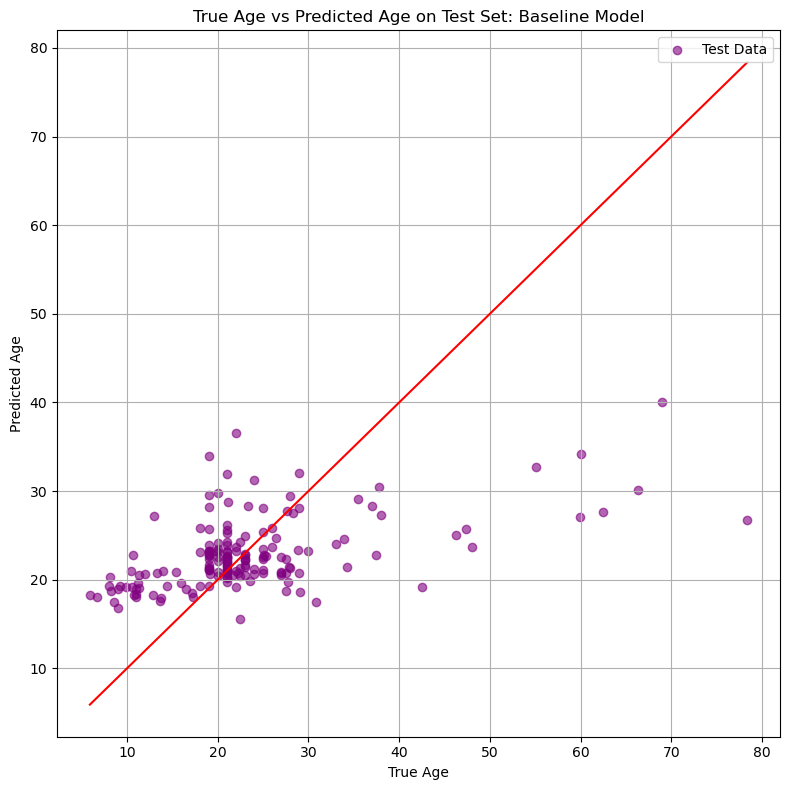

In [403]:
plot_test_restuls(e2e_test_loader, combined_model_baseline, age_norm_stats, "Baseline Model")

**Hypothesis 1 Model**

In [421]:

loaded_vol_h1_model = pickle.load(open(os.path.join(MODEL_DIR, "vol_model_proportion_not_cleaned.pkl"), "rb"))
combined_model_h1 = CombinedModel(loaded_vol_h1_model, mlp_model_proportion_h1).float().to(device)

In [424]:
test(e2e_test_loader, combined_model_h1, e2e_loss_fn, age_norm_stats)

Test loss: 0.446839, MAE: 5.504141



0.4468387210478519

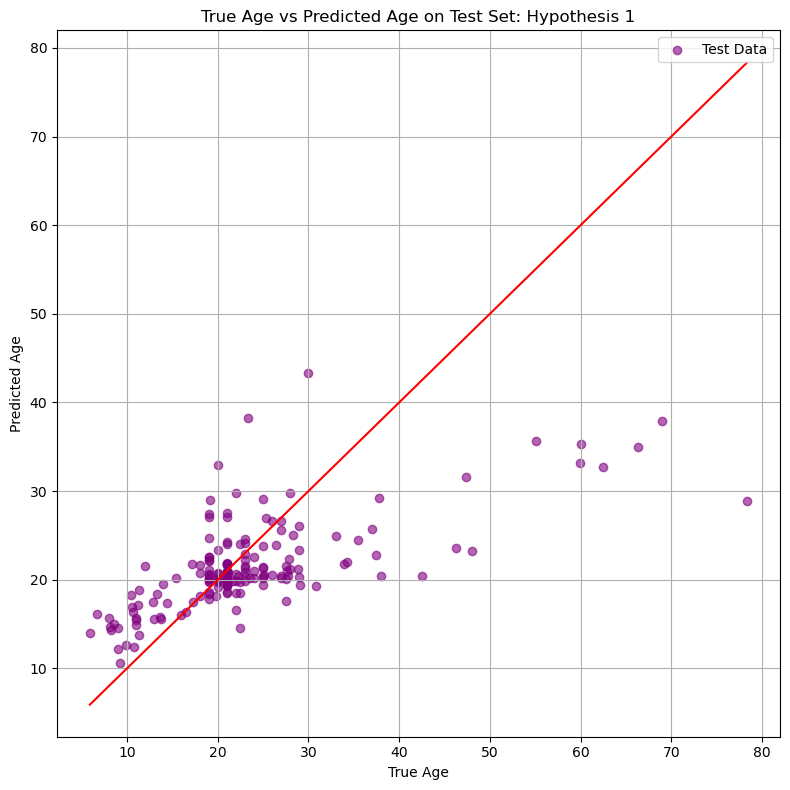

In [425]:
plot_test_restuls(e2e_test_loader,combined_model_h1,age_norm_stats, "Hypothesis 1")

**Hypothesis 2 Model**

In [422]:

loaded_vol_h2_model = pickle.load(open(os.path.join(MODEL_DIR, "vol_model_h2.pkl"), "rb"))
combined_model_h2 = CombinedModel(loaded_vol_h2_model, mlp_model_h2).float().to(device)


In [423]:
test(e2e_test_loader, combined_model_h2, e2e_loss_fn, age_norm_stats)


Test loss: 0.454672, MAE: 5.702138



0.4546721701391063

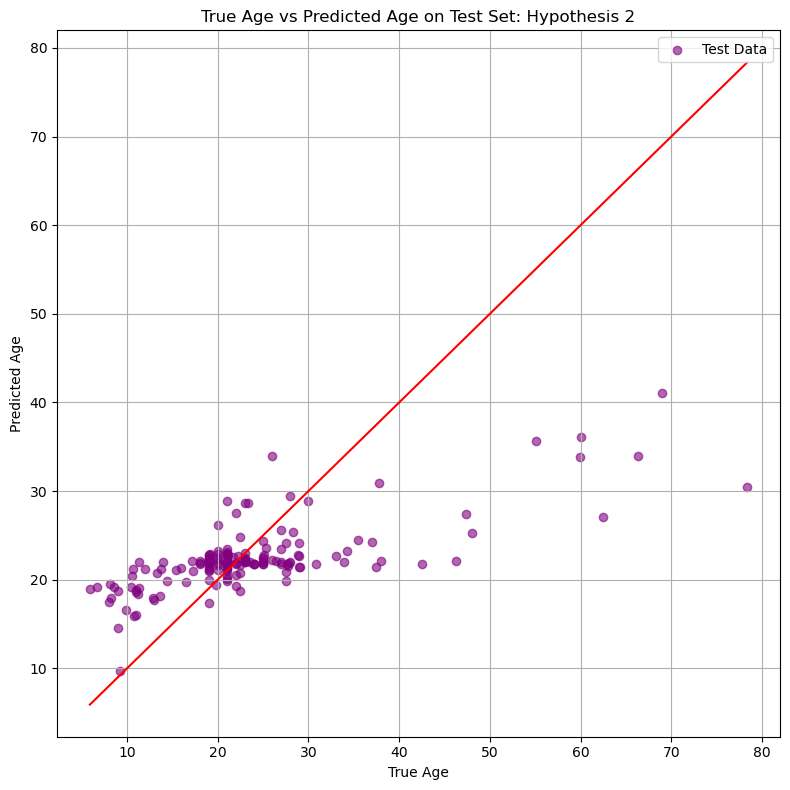

In [418]:
plot_test_restuls(e2e_test_loader,combined_model_h2,age_norm_stats, "Hypothesis 2")

**Hypothesis 3 Model**

In [408]:
combined_model_h3 = CombinedModel(volume_model_h3_early_stopping, mlp_model_h3).float().to(device)
test(e2e_test_loader, combined_model_h3, e2e_loss_fn, age_norm_stats)


Test loss: 0.377469, MAE: 5.404752



0.37746936468673603

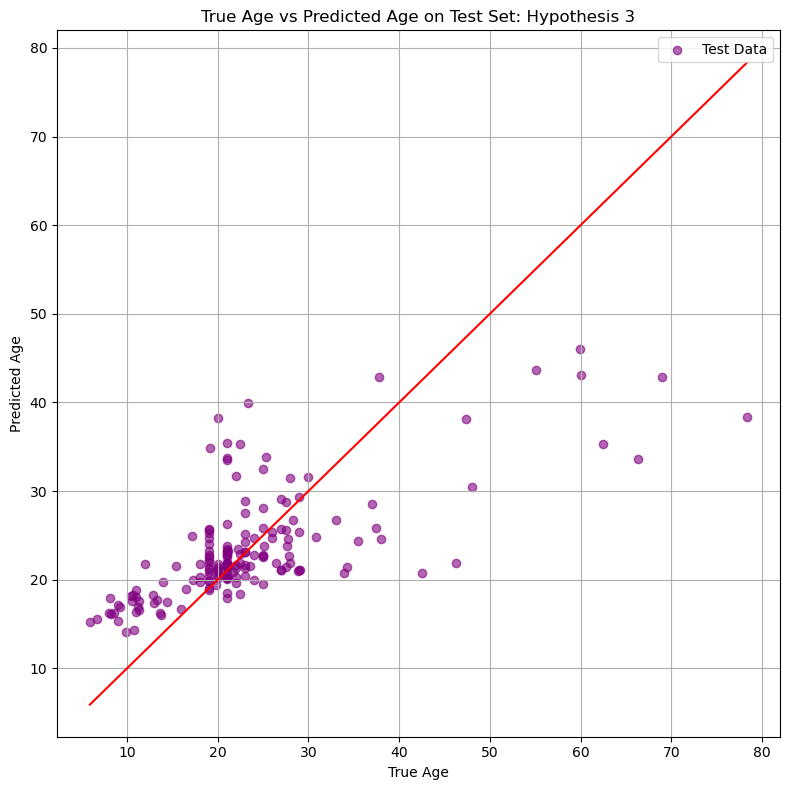

In [409]:
plot_test_restuls(e2e_test_loader,combined_model_h3,age_norm_stats, "Hypothesis 3")